# Sparse Invariant Classifier Complex Winner

## Intro
* **Date**: 10/21/2022
* **What**: Ok, I'm fucking psyched out of my mind to be working on this.  Last week, I tried implementing a classifier, but I did a bad job of implementing the mother fucker.  Basically I set it up so that reconstruction scheme relied on input values from different layers, which caused values to diverge rapidly.  Basically this time I'm going to do reconstructions only within the levels of the weights, and then I'm going to compute the winner in a more complicated way, basically by normalizing the inputs from different locations, and then weighting between the top down and bottom up contributions.  Basically ensuring that weights are trained in a stable manner, and that the top down and bottom up contributions properly contribute to which neurons win.  It'll take more time, but hopefully it'll yield better classifications.  Interestingly, I think this is maybe how we can deal with confidence.  Oh, that's fucking interesting.  Yeah, at the level of single distinguishing features, like digits for example, we can see if two neurons are super close in the extent to which they're being suggested, and then we can allocate a greater amount of attention to that particular example.  Oh, wow.  I think that might be incredibly important down the road.  
* **Why**: Basically just said this in that **What** section, look there.
* **Hopes**: A fucking MNIST classifier that actually works.  But I'm actually kinda psyched out of my mind to see if this works.
* **Limitations**: Well, the chaos of life could basically slap me in the face with its dick. But more specifically, I'm still nervous about how the second layer is actually going to train. I think that introducing a guiding prior could be incredibly useful for this particular example.  But what the fuck ever.  Let's see if we can get this to work.

## Code

In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tensorflow.keras.datasets import mnist
from tqdm import tqdm

m_len = 60_000
m_area = 28 * 28

(x_tr, y_tr), (x_te, y_te) = mnist.load_data()

x_tr = x_tr / 255.0
x_te = x_te / 255.0

In [2]:
flat_tr = x_tr.reshape(-1, m_area)
flat_cr = np.zeros((m_len, 10))

for i in range(m_len):
    flat_cr[i, y_tr[i]] = 1

flat_te = x_te.reshape(-1, m_area)
flat_ce = np.zeros((len(x_te), 10))
for i in range(len(x_te)):
    flat_ce[i, y_te[i]] = 1

gp_ftr = cp.asarray(flat_tr)
gp_cr = cp.asarray(flat_cr)
gp_fte = cp.asarray(flat_te)
gp_ce = cp.asarray(flat_ce)

In [3]:
def reconstruct(img_i, w, Kx, Ky, gp, vmax, vmin):
    s_len = 28

    img = gp[img_i]

    v = img.reshape(-1, 1)
    p = w @ v
    winners = cp.argsort(p, axis=0)[-n_w:]
    mask = cp.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w.T @ o

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape(s_len, s_len).get(), cmap="Greys", vmax=vmax, vmin=vmin)

    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(o.reshape(Ky, Kx).get(), cmap="Greys")

    plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(r.reshape(s_len, s_len).get(), cmap="Greys", vmax=vmax, vmin=vmin)

    plt.show()

In [4]:
def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

In [58]:
s1 = "NO"
s2 = "NO"
iv = "NO"

<IPython.core.display.Javascript object>


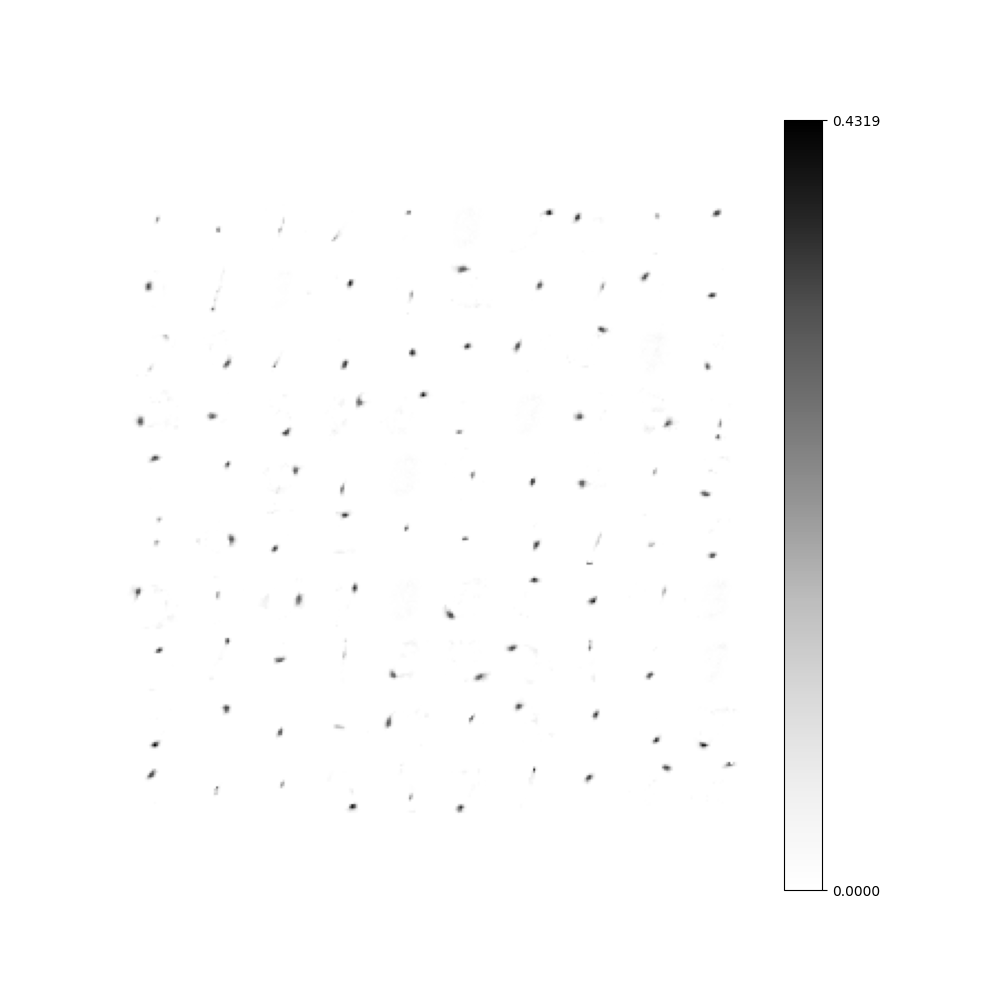

100%|██████████| 1000/1000 [00:07<00:00, 140.86it/s]


In [67]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))


m_len = 28 * 28 
tr_len = 60000


prec = 1e-10

# Sparse 1
S1x = 10
S1y = 10

NS1 = S1x * S1y

# Invariant
Ivx = 5
Ivy = 10
hw2 = 0.5

NIv = Ivx * Ivy

# Sparse 2
S2x = 5
S2y = 5
hw3 = 0.5 # How much we weight top-down vs bottom-up


NS2 = S2x * S2y

xi = 0.05


# In - Sparse 1
w1 = cp.random.uniform(0, 0.05, (NS1, m_len))
n_w1 = 20 #Number of winners

iv_b = (NS1 * NIv)
iv_t = (NS2 * NIv)

iv_syn = (iv_b) + (iv_t)
iv_init = 0.02


# Sparse 1 - Iv
w2 = cp.random.uniform(0, iv_init * iv_b / iv_syn, (NS1, NIv))
n_w2 = n_w1 #Number of winners

# Iv - Sparse 2
w3 = cp.random.uniform(0, iv_init * iv_t / iv_syn, (NS2, NIv))
n_w3 = 1

# Sparse 2 - Class
w4 = cp.random.uniform(0, 0.1, (NS2, 10))

# Count Passes
passthrough_count = 2 # How many times we go back and forth through the network
show_count = 4

debug = False
de2 = False

Nep = 10
T_s = 1000
hw1 = .5 # How much we weight top-down vs bottom-up

for ep in range(Nep):
    rand_pert = np.random.permutation(tr_len)
#     rand_pert = list(range(tr_len)) # JUST FOR DEBUGGING
    inputs = gp_ftr[rand_pert]
    outputs = gp_cr[rand_pert]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        cl = outputs[i].reshape(-1, 1)

        s1_bottom = cp.zeros((NS1, 1))
        s1_top = cp.zeros((NS1, 1))
        
        iv_bottom = cp.zeros((NIv, 1))
        iv_top = cp.zeros((NIv, 1))
        
        s2_bottom = cp.zeros((NS2, 1))
        s2_top = cp.zeros((NS2, 1))
        
#         s1 = cp.zeros((NS1, 1))
#         iv = cp.zeros((NIv, 1))
#         s2 = cp.zeros((NS2, 1))
        
        def calc_s1():
            # s1 = hw1 * (w1 @ v) + (1 - hw1) * (w2 @ iv)
            global s1_bottom, s1_top
            
            s1_bottom = w1 @ v
            s1_top = w2 @ iv_bottom
            
            s1_comp = (hw1 * s1_bottom / cp.max(s1_bottom)) + ((1 - hw1) * s1_top / cp.max(s1_top))
            s1_winners = cp.argsort(s1_comp, axis=0)[-n_w1:]
            s1_top = cp.zeros((NS1, 1))
            s1_top[s1_winners] = 1
            s1_bottom *= s1_top
            
        def calc_iv():
            # iv = hw2 * (w2.T @ s1) + (1 - hw2) * (w3.T @ s2)
            global iv_bottom, iv_top
            
            iv_bottom = w2.T @ s1_top
            iv_top = w3.T @ s2_bottom
            iv_comp = (hw2 * iv_bottom / cp.max(iv_bottom)) + ((1 - hw2) * iv_top / cp.max(iv_top))
            
            iv_winners = cp.argsort(iv_comp, axis=0)[-n_w2:]
            iv_top = cp.zeros((NIv, 1))
            iv_top[iv_winners] = 1
            iv_bottom = iv_top
            
        def calc_s2():
            # s2 = hw3 * (w3 @ iv) + (1 - hw3) * (w4 @ cl)
            global s2_bottom, s2_top
            
            s2_bottom = w3 @ iv_top
            s2_top = w4 @ cl
            s2_comp = (hw3 * s2_bottom / cp.max(s2_bottom)) + ((1 - hw3) * s2_top / cp.max(s2_top))
            
            s2_winners = cp.argsort(s2_comp, axis=0)[-n_w3:]
            s2_top = cp.zeros((NS2, 1))
            s2_top[s2_winners] = 1
            s2_bottom *= s2_top
            
        
        for _ in range(passthrough_count): 
            calc_s1()
            calc_iv()
            calc_s2()
            calc_iv()
        
#         s1 = cp.clip(s1, -1, 1)
#         iv = cp.clip(iv, -1, 1)
#         s2 = cp.clip(s2, -1, 1)
        
#         if de2:
#             print('s1', s1[:show_count])
#             print('s2', s2[:show_count])
#             print('iv', iv[:show_count])
#             print('cl', cl[:show_count])
        
        r1 = w1.T @ s1_bottom
        mod_r1 = cp.maximum(r1, prec)
        e1 = v - r1
#         e1 = cp.clip(v - r1, -1, 1)

        
        cc1 = w1 * s1_bottom * (e1 / mod_r1).T * xi
        if debug: print('nan', cp.isnan(w1 + cc1).any())
        w1 += cc1        
        
        if debug: print('max w1', cp.max(w1), cp.min(w1), cp.isnan(w1).any())
        
        r2 = w2.T @ s1_top
        mod_r2 = cp.maximum(r2, prec)
        e2 = iv_bottom - r2
#         e2 = cp.clip(o2 - r2, -1, 1)
        
        w2 += w2 * s1_top * (e2 / mod_r2).T * xi
        
        if debug: print('max w2', cp.max(w2), cp.min(w2), cp.isnan(w2).any())
        
        r3 = w3.T @ s2_bottom
        mod_r3 = cp.maximum(r3, prec)
        e3 = iv_top - r3
        
        w3 += w3 * s2_bottom * (e3 / mod_r3).T * xi
        if debug: print('max w3', cp.max(w3), cp.min(w3), cp.isnan(w3).any())

            
        r4 = w4.T @ s2_top
        mod_r4 = cp.maximum(r4, prec)
        e4 = cl - r4
        
        w4 += w4 * s2_top * (e4 / mod_r4).T * xi
        if debug: print('max w4', cp.max(w4), cp.min(w4), cp.isnan(w4).any())
        
#         w1 = cp.clip(w1, 0, 1)
#         w2 = cp.clip(w2, 0, 1)
#         w3 = cp.clip(w3, 0, 1)
#         w4 = cp.clip(w4, 0, 1)

        
    draw_weights(w1.get(), S1x, S1y, 28, fig)

Ok, this trained something.  Now I guess I need to figure out exactly what it trained...  I have a sneaking feeling that the second layer is uniform.  Like a bunch of fuzzy threes, but just at a second level...

In [68]:
def draw_iv(w, Kx, Ky, s_len_x, s_len_y, fig):
    tapestry = np.zeros((s_len_y * Ky, s_len_x * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len_y: (y + 1) * s_len_y, x * s_len_x: (x + 1) * s_len_x] = w[w_i].reshape(s_len_y, s_len_x)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

<IPython.core.display.Javascript object>


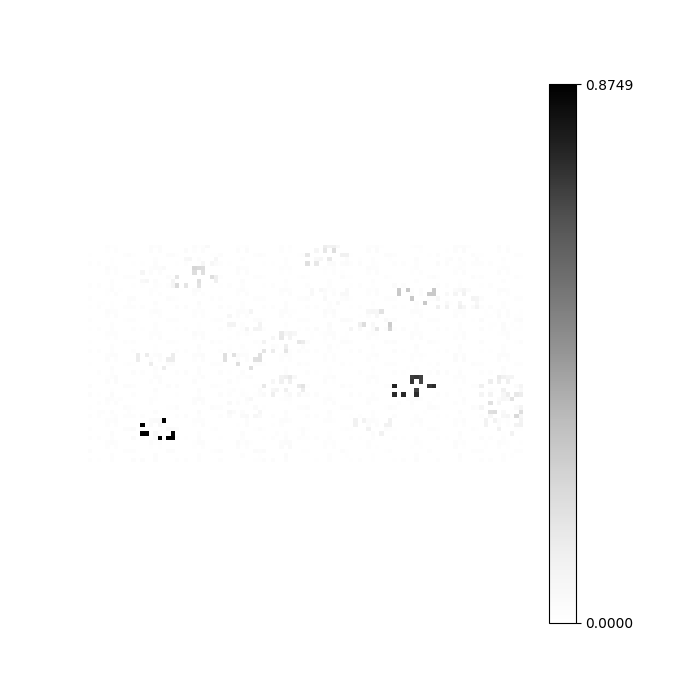

In [69]:
fig = plt.figure(figsize=(7, 7))

draw_iv(w2.get(), S1x, S1y, 10, 5, fig)

<IPython.core.display.Javascript object>


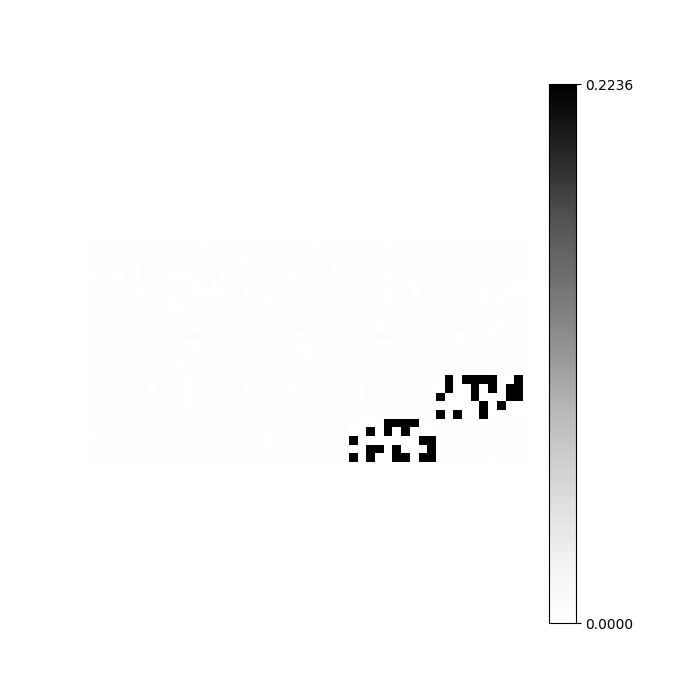

In [70]:
fig = plt.figure(figsize=(7, 7))

draw_iv(w3.get(), S2x, S2y, 10, 5, fig)

<IPython.core.display.Javascript object>


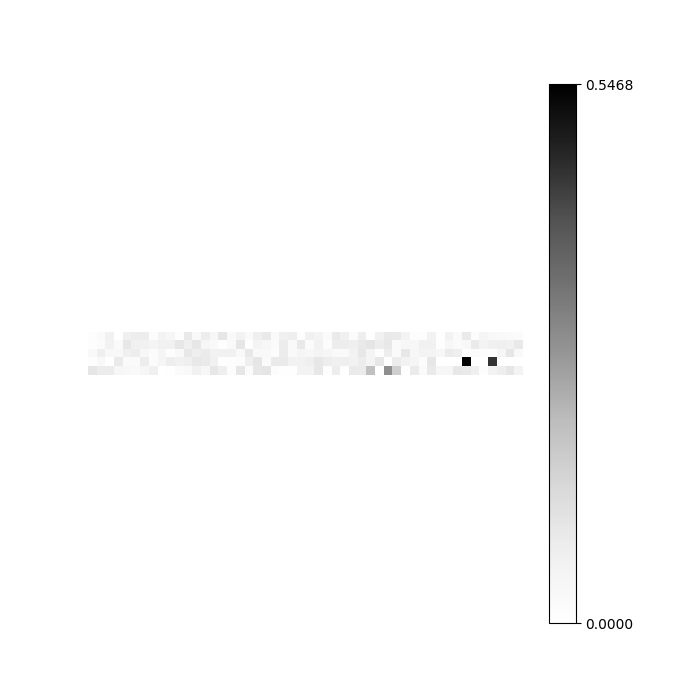

In [71]:
fig = plt.figure(figsize=(7, 7))

draw_iv(w4.get(), S2x, S2y, 10, 1, fig)

Yeah, ok, so that ain't great.  I'm going to see if I can run this for a couple of inputs, see what the prognosis is:

In [73]:
# inputs = gp_ftr[rand_pert]
# outputs = gp_cr[rand_pert]
# for i in tqdm(range(T_s)):
i = 1

v = gp_ftr[i].reshape(-1, 1)
cl = gp_cr[i].reshape(-1, 1)

s1_bottom = cp.zeros((NS1, 1))
s1_top = cp.zeros((NS1, 1))

iv_bottom = cp.zeros((NIv, 1))
iv_top = cp.zeros((NIv, 1))

s2_bottom = cp.zeros((NS2, 1))
s2_top = cp.zeros((NS2, 1))

def calc_s1():
    # s1 = hw1 * (w1 @ v) + (1 - hw1) * (w2 @ iv)
    global s1_bottom, s1_top

    s1_bottom = w1 @ v
    s1_top = w2 @ iv_bottom

    s1_comp = (hw1 * s1_bottom / cp.max(s1_bottom)) + ((1 - hw1) * s1_top / cp.max(s1_top))
    s1_winners = cp.argsort(s1_comp, axis=0)[-n_w1:]
    s1_top = cp.zeros((NS1, 1))
    s1_top[s1_winners] = 1
    s1_bottom *= s1_top

def calc_iv():
    # iv = hw2 * (w2.T @ s1) + (1 - hw2) * (w3.T @ s2)
    global iv_bottom, iv_top

    iv_bottom = w2.T @ s1_top
    iv_top = w3.T @ s2_bottom
    iv_comp = (hw2 * iv_bottom / cp.max(iv_bottom)) + ((1 - hw2) * iv_top / cp.max(iv_top))

    iv_winners = cp.argsort(iv_comp, axis=0)[-n_w2:]
    iv_top = cp.zeros((NIv, 1))
    iv_top[iv_winners] = 1
    iv_bottom = iv_top

def calc_s2():
    # s2 = hw3 * (w3 @ iv) + (1 - hw3) * (w4 @ cl)
    global s2_bottom, s2_top

    s2_bottom = w3 @ iv_top
#     s2_top = w4 @ cl
    s2_comp = (hw3 * s2_bottom / cp.max(s2_bottom)) + ((1 - hw3) * s2_top / cp.max(s2_top))

    s2_winners = cp.argsort(s2_comp, axis=0)[-n_w3:]
    s2_top = cp.zeros((NS2, 1))
    s2_top[s2_winners] = 1
    s2_bottom *= s2_top



calc_s1()
calc_iv()
calc_s2()
calc_iv()

s2_top

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.]])

Ok, I'm not entirely sure what's happening inside there.  Frankly, I think it's somewhat concerning that we're getting such weird features in the last sparse layer.  It kinda looks like something isn't training properly.  

Though, strangely enough, I feel like the training was different this time around.  Also, I feel like it's possible we literally have too many winners.  It's not properly learning structure...

<IPython.core.display.Javascript object>


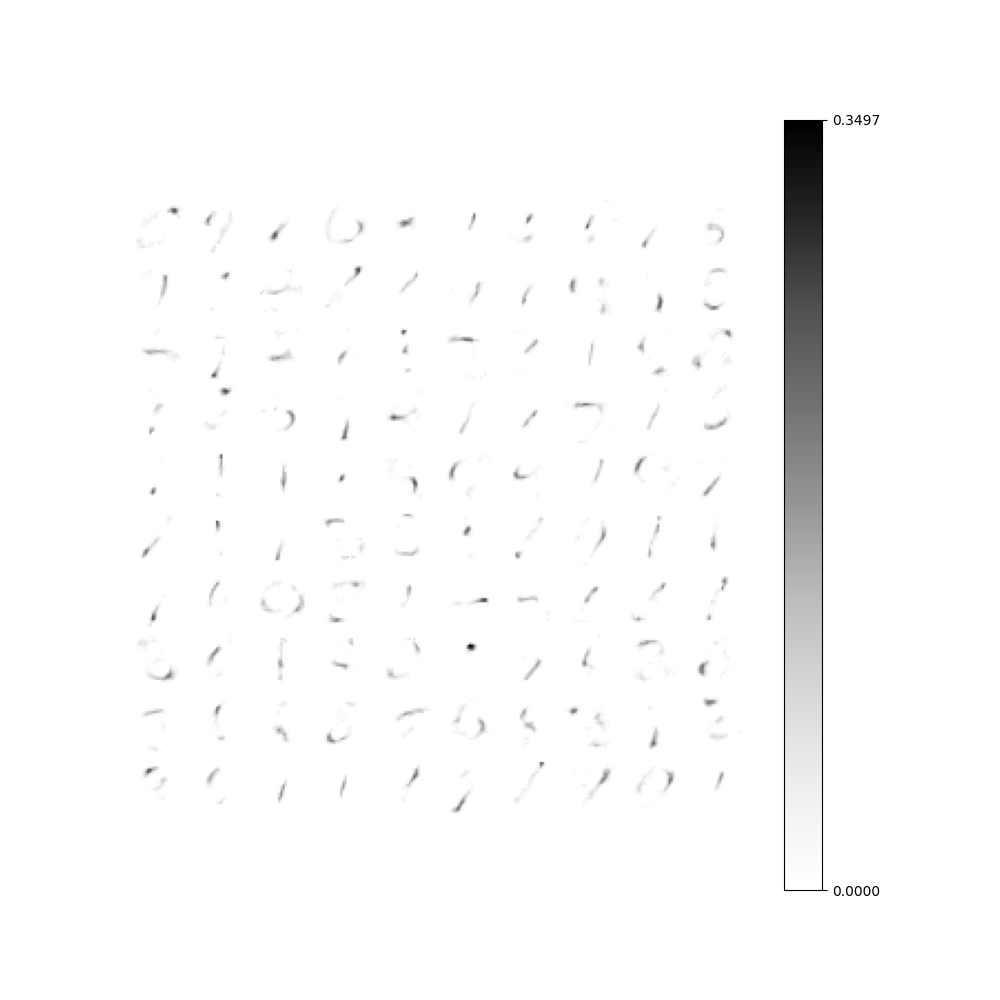

100%|██████████| 1000/1000 [00:07<00:00, 140.05it/s]


In [74]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))


m_len = 28 * 28 
tr_len = 60000


prec = 1e-10

# Sparse 1
S1x = 10
S1y = 10

NS1 = S1x * S1y

# Invariant
Ivx = 5
Ivy = 10
hw2 = 0.5

NIv = Ivx * Ivy

# Sparse 2
S2x = 5
S2y = 5
hw3 = 0.5 # How much we weight top-down vs bottom-up


NS2 = S2x * S2y

xi = 0.05


# In - Sparse 1
w1 = cp.random.uniform(0, 0.05, (NS1, m_len))
n_w1 = 10 #Number of winners

iv_b = (NS1 * NIv)
iv_t = (NS2 * NIv)

iv_syn = (iv_b) + (iv_t)
iv_init = 0.02


# Sparse 1 - Iv
w2 = cp.random.uniform(0, iv_init * iv_b / iv_syn, (NS1, NIv))
n_w2 = n_w1 #Number of winners

# Iv - Sparse 2
w3 = cp.random.uniform(0, iv_init * iv_t / iv_syn, (NS2, NIv))
n_w3 = 1

# Sparse 2 - Class
w4 = cp.random.uniform(0, 0.1, (NS2, 10))

# Count Passes
passthrough_count = 2 # How many times we go back and forth through the network
show_count = 4

debug = False
de2 = False

Nep = 10
T_s = 1000
hw1 = .5 # How much we weight top-down vs bottom-up

for ep in range(Nep):
    rand_pert = np.random.permutation(tr_len)
#     rand_pert = list(range(tr_len)) # JUST FOR DEBUGGING
    inputs = gp_ftr[rand_pert]
    outputs = gp_cr[rand_pert]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        cl = outputs[i].reshape(-1, 1)

        s1_bottom = cp.zeros((NS1, 1))
        s1_top = cp.zeros((NS1, 1))
        
        iv_bottom = cp.zeros((NIv, 1))
        iv_top = cp.zeros((NIv, 1))
        
        s2_bottom = cp.zeros((NS2, 1))
        s2_top = cp.zeros((NS2, 1))
        
#         s1 = cp.zeros((NS1, 1))
#         iv = cp.zeros((NIv, 1))
#         s2 = cp.zeros((NS2, 1))
        
        def calc_s1():
            # s1 = hw1 * (w1 @ v) + (1 - hw1) * (w2 @ iv)
            global s1_bottom, s1_top
            
            s1_bottom = w1 @ v
            s1_top = w2 @ iv_bottom
            
            s1_comp = (hw1 * s1_bottom / cp.max(s1_bottom)) + ((1 - hw1) * s1_top / cp.max(s1_top))
            s1_winners = cp.argsort(s1_comp, axis=0)[-n_w1:]
            s1_top = cp.zeros((NS1, 1))
            s1_top[s1_winners] = 1
            s1_bottom *= s1_top
            
        def calc_iv():
            # iv = hw2 * (w2.T @ s1) + (1 - hw2) * (w3.T @ s2)
            global iv_bottom, iv_top
            
            iv_bottom = w2.T @ s1_top
            iv_top = w3.T @ s2_bottom
            iv_comp = (hw2 * iv_bottom / cp.max(iv_bottom)) + ((1 - hw2) * iv_top / cp.max(iv_top))
            
            iv_winners = cp.argsort(iv_comp, axis=0)[-n_w2:]
            iv_top = cp.zeros((NIv, 1))
            iv_top[iv_winners] = 1
            iv_bottom = iv_top
            
        def calc_s2():
            # s2 = hw3 * (w3 @ iv) + (1 - hw3) * (w4 @ cl)
            global s2_bottom, s2_top
            
            s2_bottom = w3 @ iv_top
            s2_top = w4 @ cl
            s2_comp = (hw3 * s2_bottom / cp.max(s2_bottom)) + ((1 - hw3) * s2_top / cp.max(s2_top))
            
            s2_winners = cp.argsort(s2_comp, axis=0)[-n_w3:]
            s2_top = cp.zeros((NS2, 1))
            s2_top[s2_winners] = 1
            s2_bottom *= s2_top
            
        
        for _ in range(passthrough_count): 
            calc_s1()
            calc_iv()
            calc_s2()
            calc_iv()
        
        
        r1 = w1.T @ s1_bottom
        mod_r1 = cp.maximum(r1, prec)
        e1 = v - r1

        
        cc1 = w1 * s1_bottom * (e1 / mod_r1).T * xi
        if debug: print('nan', cp.isnan(w1 + cc1).any())
        w1 += cc1        
        
        if debug: print('max w1', cp.max(w1), cp.min(w1), cp.isnan(w1).any())
        
        r2 = w2.T @ s1_top
        mod_r2 = cp.maximum(r2, prec)
        e2 = iv_bottom - r2
        
        w2 += w2 * s1_top * (e2 / mod_r2).T * xi
        
        if debug: print('max w2', cp.max(w2), cp.min(w2), cp.isnan(w2).any())
        
        r3 = w3.T @ s2_bottom
        mod_r3 = cp.maximum(r3, prec)
        e3 = iv_top - r3
        
        w3 += w3 * s2_bottom * (e3 / mod_r3).T * xi
        if debug: print('max w3', cp.max(w3), cp.min(w3), cp.isnan(w3).any())

            
        r4 = w4.T @ s2_top
        mod_r4 = cp.maximum(r4, prec)
        e4 = cl - r4
        
        w4 += w4 * s2_top * (e4 / mod_r4).T * xi
        if debug: print('max w4', cp.max(w4), cp.min(w4), cp.isnan(w4).any())
        
    draw_weights(w1.get(), S1x, S1y, 28, fig)

<IPython.core.display.Javascript object>


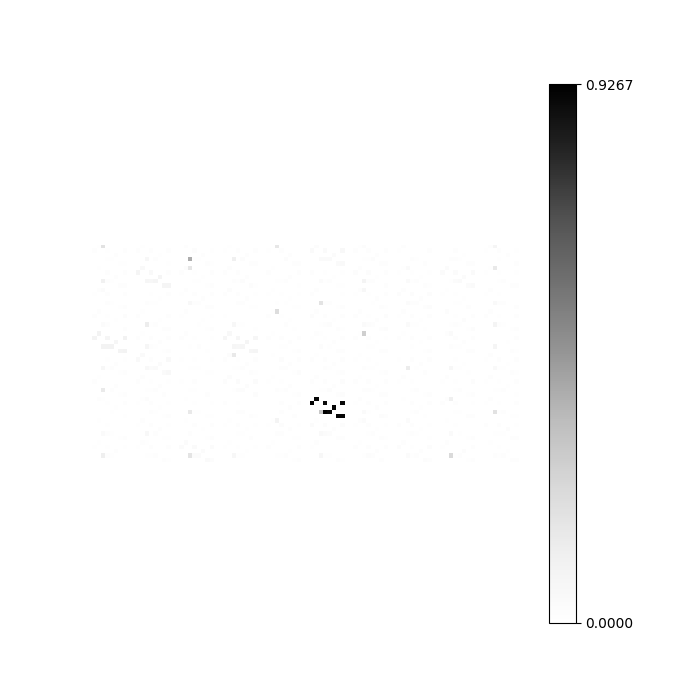

In [75]:
fig = plt.figure(figsize=(7, 7))

draw_iv(w2.get(), S1x, S1y, 10, 5, fig)

<IPython.core.display.Javascript object>


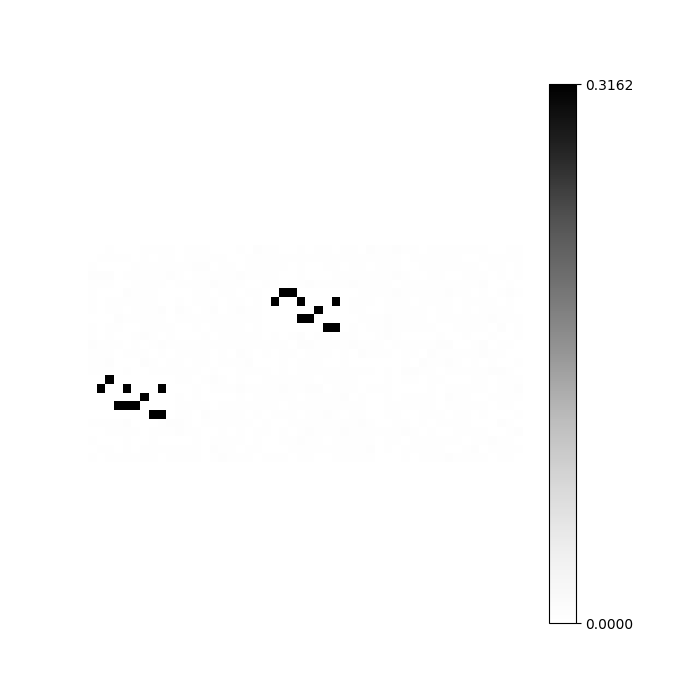

In [76]:
fig = plt.figure(figsize=(7, 7))

draw_iv(w3.get(), S2x, S2y, 10, 5, fig)

In [ ]:
s_len = 28

img = gp[img_i]

v = img.reshape(-1, 1)
p = w @ v
winners = cp.argsort(p, axis=0)[-n_w:]
mask = cp.zeros((N, 1))
mask[winners] = 1
o = mask * p
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len).get(), cmap="Greys", vmax=vmax, vmin=vmin)

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx).get(), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len).get(), cmap="Greys", vmax=vmax, vmin=vmin)

plt.show()

<IPython.core.display.Javascript object>


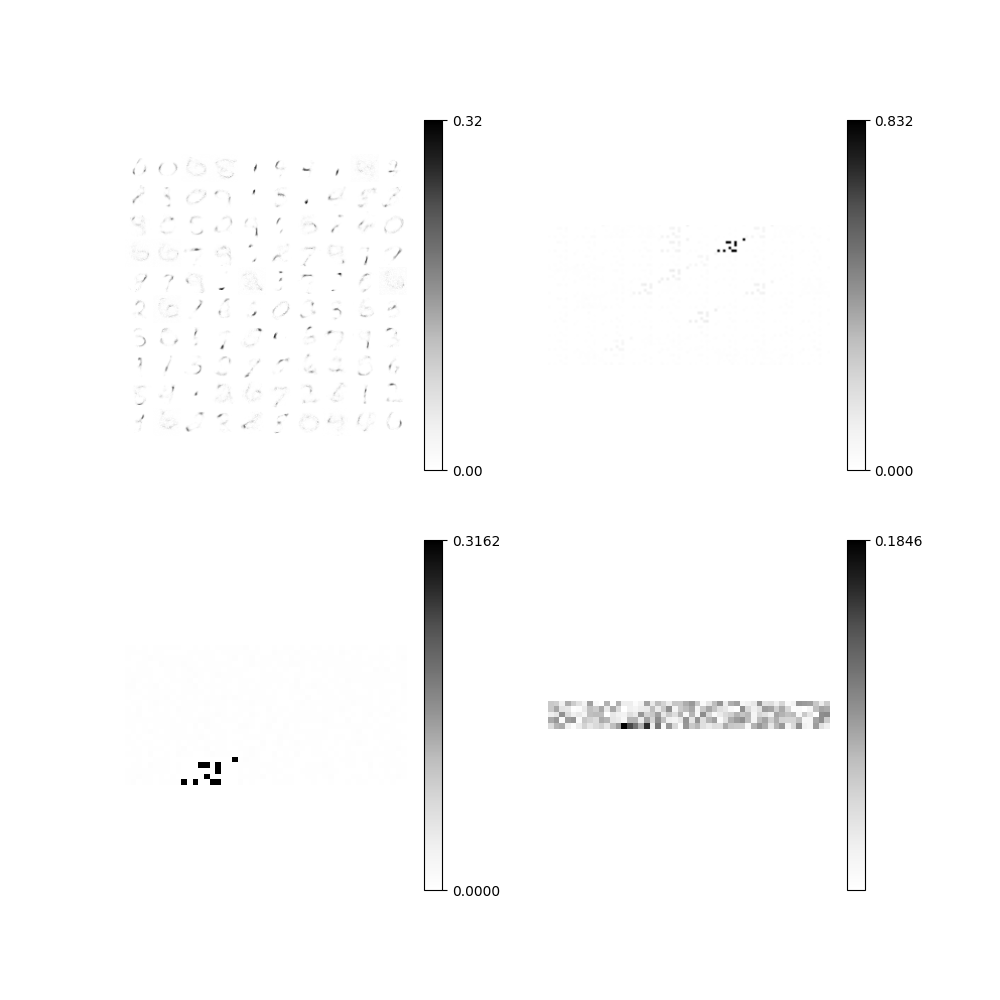

In [96]:
fig = plt.figure(figsize=(10, 10))

def draw_higher_order_weights(fig):
    fig.clf()
    def draw_iv(w, Kx, Ky, s_len_x, s_len_y, fig, i):
        tapestry = np.zeros((s_len_y * Ky, s_len_x * Kx))

        w_i = 0
        for y in range(Ky):
            for x in range(Kx):
                tapestry[y * s_len_y: (y + 1) * s_len_y, x * s_len_x: (x + 1) * s_len_x] = w[w_i].reshape(s_len_y, s_len_x)
                w_i += 1

        plt.subplot(2, 2, i)
    #     plt.clf()        
        max_val = np.max(tapestry)
        im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
        fig.colorbar(im, ticks=[0, max_val])
        plt.axis("off")
#         fig.canvas.draw()
    draw_iv(w1.get(), S1x, S1y, 28, 28, fig, 1)
    draw_iv(w2.get(), S1x, S1y, Ivy, Ivx, fig, 2)
    draw_iv(w3.get(), S2x, S2y, Ivy, Ivx, fig, 3)
    draw_iv(w4.get(), S2x, S2y, 10, 1, fig, 4)
    fig.canvas.draw()

draw_higher_order_weights(fig)

I'm wondering if the best way to get the invariant layers to train is to continually hit it up with noise that it has to train away.  Certainly worth a try...

<IPython.core.display.Javascript object>


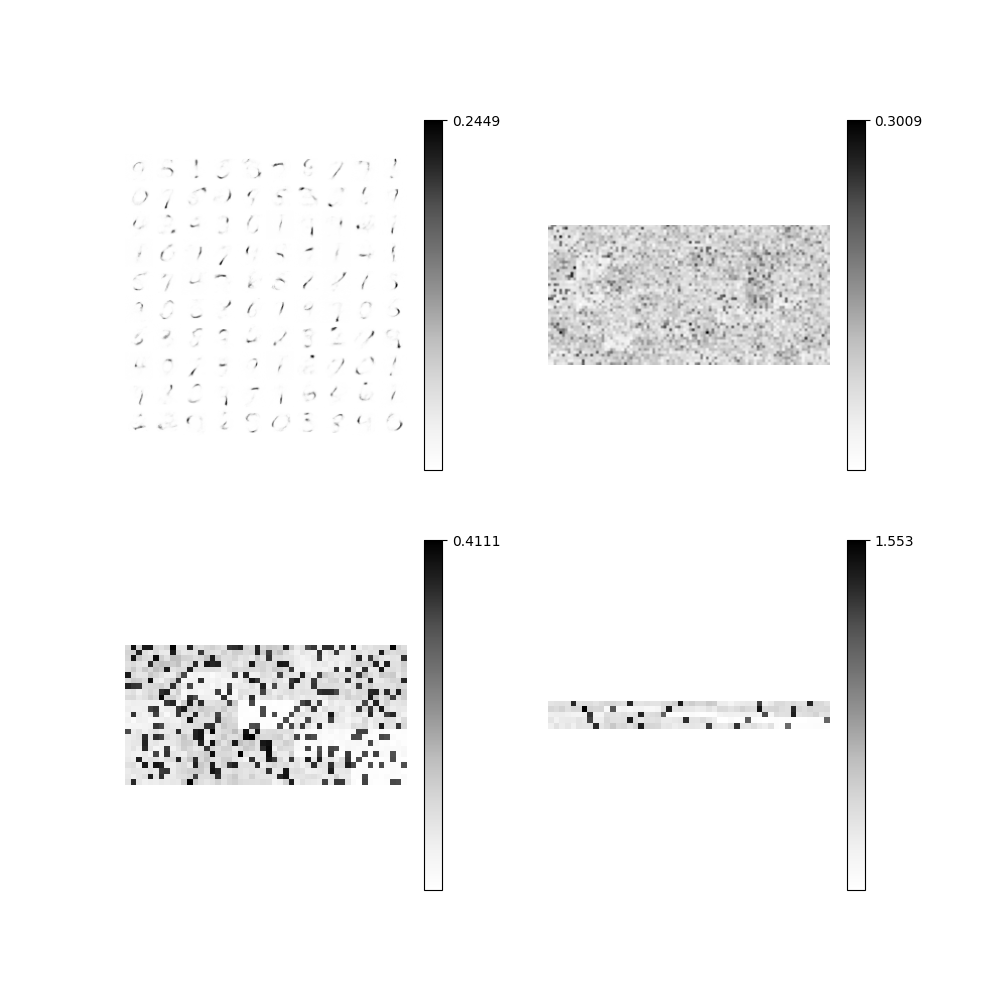

100%|██████████| 1000/1000 [00:07<00:00, 138.71it/s]


In [110]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))


m_len = 28 * 28 
tr_len = 60000


prec = 1e-10

# Sparse 1
S1x = 10
S1y = 10

NS1 = S1x * S1y

# Invariant
Ivx = 5
Ivy = 10
hw2 = 0.5

NIv = Ivx * Ivy

# Sparse 2
S2x = 5
S2y = 5
hw3 = 0.5 # How much we weight top-down vs bottom-up


NS2 = S2x * S2y

xi = 0.05


# In - Sparse 1
w1 = cp.random.uniform(0, 0.05, (NS1, m_len))
n_w1 = 10 #Number of winners

iv_b = (NS1 * NIv)
iv_t = (NS2 * NIv)

iv_syn = (iv_b) + (iv_t)
iv_init = 0.02


# Sparse 1 - Iv
w2 = cp.random.uniform(0, 0.1, (NS1, NIv))
n_w2 = n_w1 #Number of winners

# Iv - Sparse 2
w3 = cp.random.uniform(0, 0.5, (NS2, NIv))
n_w3 = 1

# Sparse 2 - Class
w4 = cp.random.uniform(0, 0.1, (NS2, 10))

# Count Passes
passthrough_count = 2 # How many times we go back and forth through the network
show_count = 4

debug = False
de2 = False

Nep = 10
T_s = 1000
hw1 = .5 # How much we weight top-down vs bottom-up

for ep in range(Nep):
    rand_pert = np.random.permutation(tr_len)
#     rand_pert = list(range(tr_len)) # JUST FOR DEBUGGING
    inputs = gp_ftr[rand_pert]
    outputs = gp_cr[rand_pert]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        cl = outputs[i].reshape(-1, 1)

        s1_bottom = cp.zeros((NS1, 1))
        s1_top = cp.zeros((NS1, 1))
        
        iv_bottom = cp.zeros((NIv, 1))
        iv_top = cp.zeros((NIv, 1))
        
        s2_bottom = cp.zeros((NS2, 1))
        s2_top = cp.zeros((NS2, 1))
        
        
        def calc_s1():
            global s1_bottom, s1_top
            
            s1_bottom = w1 @ v
            s1_top = w2 @ iv_bottom
            
            s1_comp = (hw1 * s1_bottom / cp.max(s1_bottom)) + ((1 - hw1) * s1_top / cp.max(s1_top))
            s1_winners = cp.argsort(s1_comp, axis=0)[-n_w1:]
            s1_top = cp.zeros((NS1, 1))
            s1_top[s1_winners] = 1
            s1_bottom *= s1_top
            
        def calc_iv():
            global iv_bottom, iv_top
            
            iv_bottom = w2.T @ s1_top
            iv_top = w3.T @ s2_bottom
            iv_comp = (hw2 * iv_bottom / cp.max(iv_bottom)) + ((1 - hw2) * iv_top / cp.max(iv_top))
            
            iv_winners = cp.argsort(iv_comp, axis=0)[-n_w2:]
            iv_top = cp.zeros((NIv, 1))
            iv_top[iv_winners] = 1
            iv_bottom = iv_top
            
        def calc_s2():
            global s2_bottom, s2_top
            
            s2_bottom = w3 @ iv_top
            s2_top = w4 @ cl
            s2_comp = (hw3 * s2_bottom / cp.max(s2_bottom)) + ((1 - hw3) * s2_top / cp.max(s2_top))
            
            s2_winners = cp.argsort(s2_comp, axis=0)[-n_w3:]
            s2_top = cp.zeros((NS2, 1))
            s2_top[s2_winners] = 1
            s2_bottom *= s2_top
            
        
        for _ in range(passthrough_count): 
            calc_s1()
            calc_iv()
            calc_s2()
            calc_iv()
        
        
        r1 = w1.T @ s1_bottom
        mod_r1 = cp.maximum(r1, prec)
        e1 = v - r1

        
        cc1 = w1 * s1_bottom * (e1 / mod_r1).T * xi
        w1 += cc1        
                
        r2 = w2.T @ s1_top
        mod_r2 = cp.maximum(r2, prec)
        e2 = iv_bottom - r2
        
        w2 += w2 * s1_top * (e2 / mod_r2).T * xi
                
        r3 = w3.T @ s2_bottom
        mod_r3 = cp.maximum(r3, prec)
        e3 = iv_top - r3
        
        w3 += w3 * s2_bottom * (e3 / mod_r3).T * xi
            
        r4 = w4.T @ s2_top
        mod_r4 = cp.maximum(r4, prec)
        e4 = cl - r4
        
        w4 += w4 * s2_top * (e4 / mod_r4).T * xi
        
        if i % 50 == 0:
            w1 += cp.random.uniform(0, 0.001, (NS1, m_len))
            w2 += cp.random.uniform(0, 0.05, (NS1, NIv))
            w3 += cp.random.uniform(0, 0.05, (NS2, NIv))
            w4 += cp.random.uniform(0, 0.05, (NS2, 10))
        
    draw_higher_order_weights(fig)

Huh.  I think this might be working?  The noise seems to critical to getting this shit to work.  Let's see what degree of classification we're getting...

In [148]:
def classify(i):
    v = gp_fte[i].reshape(-1, 1)
    cl = gp_ce[i].reshape(-1, 1)

    s1_bottom = cp.zeros((NS1, 1))
    s1_top = cp.zeros((NS1, 1))

    iv_bottom = cp.zeros((NIv, 1))
    iv_top = cp.zeros((NIv, 1))

    s2_bottom = cp.zeros((NS2, 1))
    s2_top = cp.zeros((NS2, 1))

    s1_bottom = w1 @ v

    s1_comp = (hw1 * s1_bottom / cp.max(s1_bottom)) # + ((1 - hw1) * s1_top / cp.max(s1_top))
    s1_winners = cp.argsort(s1_comp, axis=0)[-n_w1:]
    s1_top = cp.zeros((NS1, 1))
    s1_top[s1_winners] = 1
    s1_bottom *= s1_top

    iv_bottom = w2.T @ s1_top
    iv_comp = (hw2 * iv_bottom / cp.max(iv_bottom)) #+ ((1 - hw2) * iv_top / cp.max(iv_top))

    iv_winners = cp.argsort(iv_comp, axis=0)[-n_w2:]
    iv_top = cp.zeros((NIv, 1))
    iv_top[iv_winners] = 1
    iv_bottom = iv_top

    s2_bottom = w3 @ iv_top
    s2_comp = (hw3 * s2_bottom / cp.max(s2_bottom)) # + ((1 - hw3) * s2_top / cp.max(s2_top))

    s2_winners = cp.argsort(s2_comp, axis=0)[-n_w3:]
    s2_top = cp.zeros((NS2, 1))
    s2_top[s2_winners] = 1
    s2_bottom *= s2_top
    
    cls = w4.T @ s2_top
    
    pred = cp.argmax(cls)
    real = cp.argmax(cl)
    
    return pred == real, pred, real

def accuracy(num):
    total = 0
    for i in range(num):
        corr, _, _ = classify(i)
        if corr:
            total += 1
    print("Accuracy: ", total / num)


In [149]:
accuracy(1000)

Accuracy:  0.558


<IPython.core.display.Javascript object>


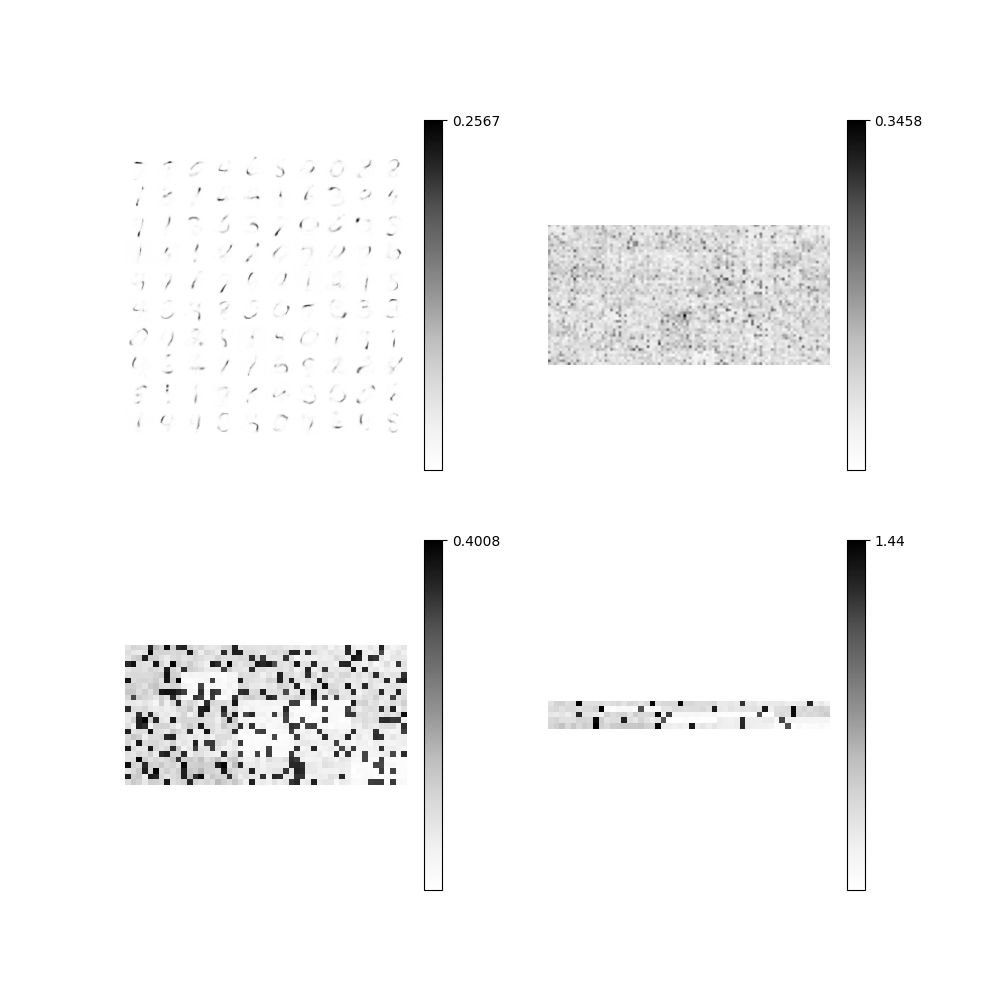

100%|██████████| 1000/1000 [00:07<00:00, 134.52it/s]


Accuracy:  0.496


100%|██████████| 1000/1000 [00:07<00:00, 139.05it/s]


Accuracy:  0.476


100%|██████████| 1000/1000 [00:07<00:00, 140.38it/s]


Accuracy:  0.604


100%|██████████| 1000/1000 [00:07<00:00, 137.51it/s]


Accuracy:  0.574


100%|██████████| 1000/1000 [00:07<00:00, 138.94it/s]


Accuracy:  0.52


100%|██████████| 1000/1000 [00:07<00:00, 140.98it/s]


Accuracy:  0.6


100%|██████████| 1000/1000 [00:07<00:00, 139.87it/s]


Accuracy:  0.504


100%|██████████| 1000/1000 [00:07<00:00, 135.83it/s]


Accuracy:  0.524


100%|██████████| 1000/1000 [00:07<00:00, 137.92it/s]


Accuracy:  0.52


100%|██████████| 1000/1000 [00:07<00:00, 137.93it/s]


Accuracy:  0.644


In [147]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))


m_len = 28 * 28 
tr_len = 60000


prec = 1e-10

# Sparse 1
S1x = 10
S1y = 10

NS1 = S1x * S1y

# Invariant
Ivx = 5
Ivy = 10
hw2 = 0.5

NIv = Ivx * Ivy

# Sparse 2
S2x = 5
S2y = 5
hw3 = 0.5 # How much we weight top-down vs bottom-up


NS2 = S2x * S2y

xi = 0.05


# In - Sparse 1
w1 = cp.random.uniform(0, 0.05, (NS1, m_len))
n_w1 = 10 #Number of winners

iv_b = (NS1 * NIv)
iv_t = (NS2 * NIv)

iv_syn = (iv_b) + (iv_t)
iv_init = 0.02


# Sparse 1 - Iv
w2 = cp.random.uniform(0, 0.1, (NS1, NIv))
n_w2 = n_w1 #Number of winners

# Iv - Sparse 2
w3 = cp.random.uniform(0, 0.5, (NS2, NIv))
n_w3 = 1

# Sparse 2 - Class
w4 = cp.random.uniform(0, 0.1, (NS2, 10))

# Count Passes
passthrough_count = 2 # How many times we go back and forth through the network
show_count = 4

debug = False
de2 = False

Nep = 10
T_s = 1000
hw1 = .5 # How much we weight top-down vs bottom-up

for ep in range(Nep):
    rand_pert = np.random.permutation(tr_len)
#     rand_pert = list(range(tr_len)) # JUST FOR DEBUGGING
    inputs = gp_ftr[rand_pert]
    outputs = gp_cr[rand_pert]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        cl = outputs[i].reshape(-1, 1)

        s1_bottom = cp.zeros((NS1, 1))
        s1_top = cp.zeros((NS1, 1))
        
        iv_bottom = cp.zeros((NIv, 1))
        iv_top = cp.zeros((NIv, 1))
        
        s2_bottom = cp.zeros((NS2, 1))
        s2_top = cp.zeros((NS2, 1))
        
        
        def calc_s1():
            global s1_bottom, s1_top
            
            s1_bottom = w1 @ v
            s1_top = w2 @ iv_bottom
            
            s1_comp = (hw1 * s1_bottom / cp.max(s1_bottom)) + ((1 - hw1) * s1_top / cp.max(s1_top))
            s1_winners = cp.argsort(s1_comp, axis=0)[-n_w1:]
            s1_top = cp.zeros((NS1, 1))
            s1_top[s1_winners] = 1
            s1_bottom *= s1_top
            
        def calc_iv():
            global iv_bottom, iv_top
            
            iv_bottom = w2.T @ s1_top
            iv_top = w3.T @ s2_bottom
            iv_comp = (hw2 * iv_bottom / cp.max(iv_bottom)) + ((1 - hw2) * iv_top / cp.max(iv_top))
            
            iv_winners = cp.argsort(iv_comp, axis=0)[-n_w2:]
            iv_top = cp.zeros((NIv, 1))
            iv_top[iv_winners] = 1
            iv_bottom = iv_top
            
        def calc_s2():
            global s2_bottom, s2_top
            
            s2_bottom = w3 @ iv_top
            s2_top = w4 @ cl
            s2_comp = (hw3 * s2_bottom / cp.max(s2_bottom)) + ((1 - hw3) * s2_top / cp.max(s2_top))
            
            s2_winners = cp.argsort(s2_comp, axis=0)[-n_w3:]
            s2_top = cp.zeros((NS2, 1))
            s2_top[s2_winners] = 1
            s2_bottom *= s2_top
            
        
        for _ in range(passthrough_count): 
            calc_s1()
            calc_iv()
            calc_s2()
            calc_iv()
        
        
        r1 = w1.T @ s1_bottom
        mod_r1 = cp.maximum(r1, prec)
        e1 = v - r1

        
        cc1 = w1 * s1_bottom * (e1 / mod_r1).T * xi
        w1 += cc1        
                
        r2 = w2.T @ s1_top
        mod_r2 = cp.maximum(r2, prec)
        e2 = iv_bottom - r2
        
        w2 += w2 * s1_top * (e2 / mod_r2).T * xi
                
        r3 = w3.T @ s2_bottom
        mod_r3 = cp.maximum(r3, prec)
        e3 = iv_top - r3
        
        w3 += w3 * s2_bottom * (e3 / mod_r3).T * xi
            
        r4 = w4.T @ s2_top
        mod_r4 = cp.maximum(r4, prec)
        e4 = cl - r4
        
        w4 += w4 * s2_top * (e4 / mod_r4).T * xi
        
        if i % 50 == 0:
            w1 += cp.random.uniform(0, 0.001, (NS1, m_len))
            w2 += cp.random.uniform(0, 0.05, (NS1, NIv))
            w3 += cp.random.uniform(0, 0.05, (NS2, NIv))
            w4 += cp.random.uniform(0, 0.05, (NS2, 10))
        
    draw_higher_order_weights(fig)
    accuracy(500)

Ok, I'm going to see if I can get this to increase by increasing the number of winners

<IPython.core.display.Javascript object>


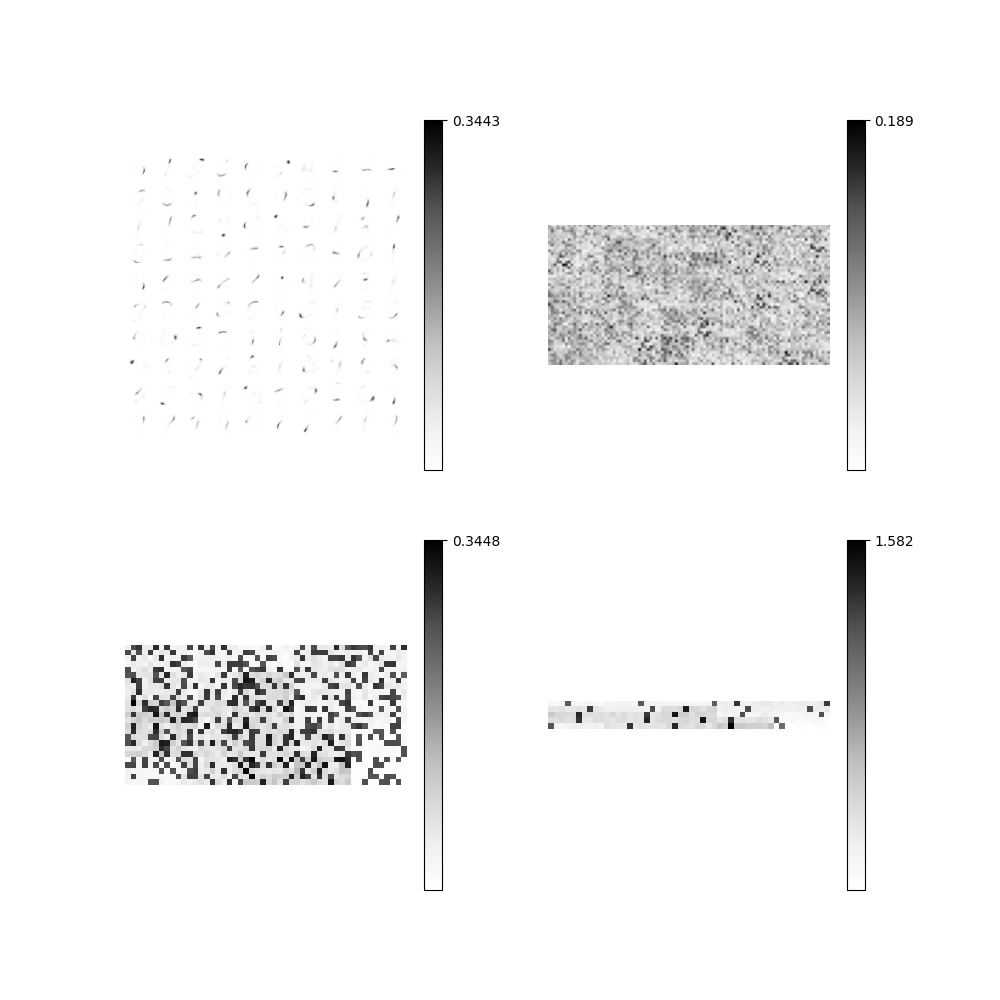

100%|██████████| 1000/1000 [00:07<00:00, 138.01it/s]


Accuracy:  0.214


100%|██████████| 1000/1000 [00:07<00:00, 139.50it/s]


Accuracy:  0.244


100%|██████████| 1000/1000 [00:07<00:00, 140.06it/s]


Accuracy:  0.37


100%|██████████| 1000/1000 [00:07<00:00, 137.56it/s]


Accuracy:  0.334


100%|██████████| 1000/1000 [00:07<00:00, 139.24it/s]


Accuracy:  0.258


100%|██████████| 1000/1000 [00:07<00:00, 138.54it/s]


Accuracy:  0.322


100%|██████████| 1000/1000 [00:07<00:00, 137.93it/s]


Accuracy:  0.192


100%|██████████| 1000/1000 [00:07<00:00, 139.55it/s]


Accuracy:  0.152


100%|██████████| 1000/1000 [00:07<00:00, 137.52it/s]


Accuracy:  0.21


100%|██████████| 1000/1000 [00:07<00:00, 137.37it/s]


Accuracy:  0.256


In [150]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))


m_len = 28 * 28 
tr_len = 60000


prec = 1e-10

# Sparse 1
S1x = 10
S1y = 10

NS1 = S1x * S1y

# Invariant
Ivx = 5
Ivy = 10
hw2 = 0.5

NIv = Ivx * Ivy

# Sparse 2
S2x = 5
S2y = 5
hw3 = 0.5 # How much we weight top-down vs bottom-up


NS2 = S2x * S2y

xi = 0.05


# In - Sparse 1
w1 = cp.random.uniform(0, 0.05, (NS1, m_len))
n_w1 = 15 #Number of winners

iv_b = (NS1 * NIv)
iv_t = (NS2 * NIv)

iv_syn = (iv_b) + (iv_t)
iv_init = 0.02


# Sparse 1 - Iv
w2 = cp.random.uniform(0, 0.1, (NS1, NIv))
n_w2 = n_w1 #Number of winners

# Iv - Sparse 2
w3 = cp.random.uniform(0, 0.5, (NS2, NIv))
n_w3 = 1

# Sparse 2 - Class
w4 = cp.random.uniform(0, 0.1, (NS2, 10))

# Count Passes
passthrough_count = 2 # How many times we go back and forth through the network
show_count = 4

debug = False
de2 = False

Nep = 10
T_s = 1000
hw1 = .5 # How much we weight top-down vs bottom-up

for ep in range(Nep):
    rand_pert = np.random.permutation(tr_len)
#     rand_pert = list(range(tr_len)) # JUST FOR DEBUGGING
    inputs = gp_ftr[rand_pert]
    outputs = gp_cr[rand_pert]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        cl = outputs[i].reshape(-1, 1)

        s1_bottom = cp.zeros((NS1, 1))
        s1_top = cp.zeros((NS1, 1))
        
        iv_bottom = cp.zeros((NIv, 1))
        iv_top = cp.zeros((NIv, 1))
        
        s2_bottom = cp.zeros((NS2, 1))
        s2_top = cp.zeros((NS2, 1))
        
        
        def calc_s1():
            global s1_bottom, s1_top
            
            s1_bottom = w1 @ v
            s1_top = w2 @ iv_bottom
            
            s1_comp = (hw1 * s1_bottom / cp.max(s1_bottom)) + ((1 - hw1) * s1_top / cp.max(s1_top))
            s1_winners = cp.argsort(s1_comp, axis=0)[-n_w1:]
            s1_top = cp.zeros((NS1, 1))
            s1_top[s1_winners] = 1
            s1_bottom *= s1_top
            
        def calc_iv():
            global iv_bottom, iv_top
            
            iv_bottom = w2.T @ s1_top
            iv_top = w3.T @ s2_bottom
            iv_comp = (hw2 * iv_bottom / cp.max(iv_bottom)) + ((1 - hw2) * iv_top / cp.max(iv_top))
            
            iv_winners = cp.argsort(iv_comp, axis=0)[-n_w2:]
            iv_top = cp.zeros((NIv, 1))
            iv_top[iv_winners] = 1
            iv_bottom = iv_top
            
        def calc_s2():
            global s2_bottom, s2_top
            
            s2_bottom = w3 @ iv_top
            s2_top = w4 @ cl
            s2_comp = (hw3 * s2_bottom / cp.max(s2_bottom)) + ((1 - hw3) * s2_top / cp.max(s2_top))
            
            s2_winners = cp.argsort(s2_comp, axis=0)[-n_w3:]
            s2_top = cp.zeros((NS2, 1))
            s2_top[s2_winners] = 1
            s2_bottom *= s2_top
            
        
        for _ in range(passthrough_count): 
            calc_s1()
            calc_iv()
            calc_s2()
            calc_iv()
        
        
        r1 = w1.T @ s1_bottom
        mod_r1 = cp.maximum(r1, prec)
        e1 = v - r1

        
        cc1 = w1 * s1_bottom * (e1 / mod_r1).T * xi
        w1 += cc1        
                
        r2 = w2.T @ s1_top
        mod_r2 = cp.maximum(r2, prec)
        e2 = iv_bottom - r2
        
        w2 += w2 * s1_top * (e2 / mod_r2).T * xi
                
        r3 = w3.T @ s2_bottom
        mod_r3 = cp.maximum(r3, prec)
        e3 = iv_top - r3
        
        w3 += w3 * s2_bottom * (e3 / mod_r3).T * xi
            
        r4 = w4.T @ s2_top
        mod_r4 = cp.maximum(r4, prec)
        e4 = cl - r4
        
        w4 += w4 * s2_top * (e4 / mod_r4).T * xi
        
        if i % 50 == 0:
            w1 += cp.random.uniform(0, 0.001, (NS1, m_len))
            w2 += cp.random.uniform(0, 0.05, (NS1, NIv))
            w3 += cp.random.uniform(0, 0.05, (NS2, NIv))
            w4 += cp.random.uniform(0, 0.05, (NS2, 10))
        
    draw_higher_order_weights(fig)
    accuracy(500)

Yikes.  Well, ok.  Frankly, I have half a mind to just do two sparse layers.  Fuck.  Ok, I'm going to increase the size of the second sparse layer, see if that helps at all...

<IPython.core.display.Javascript object>


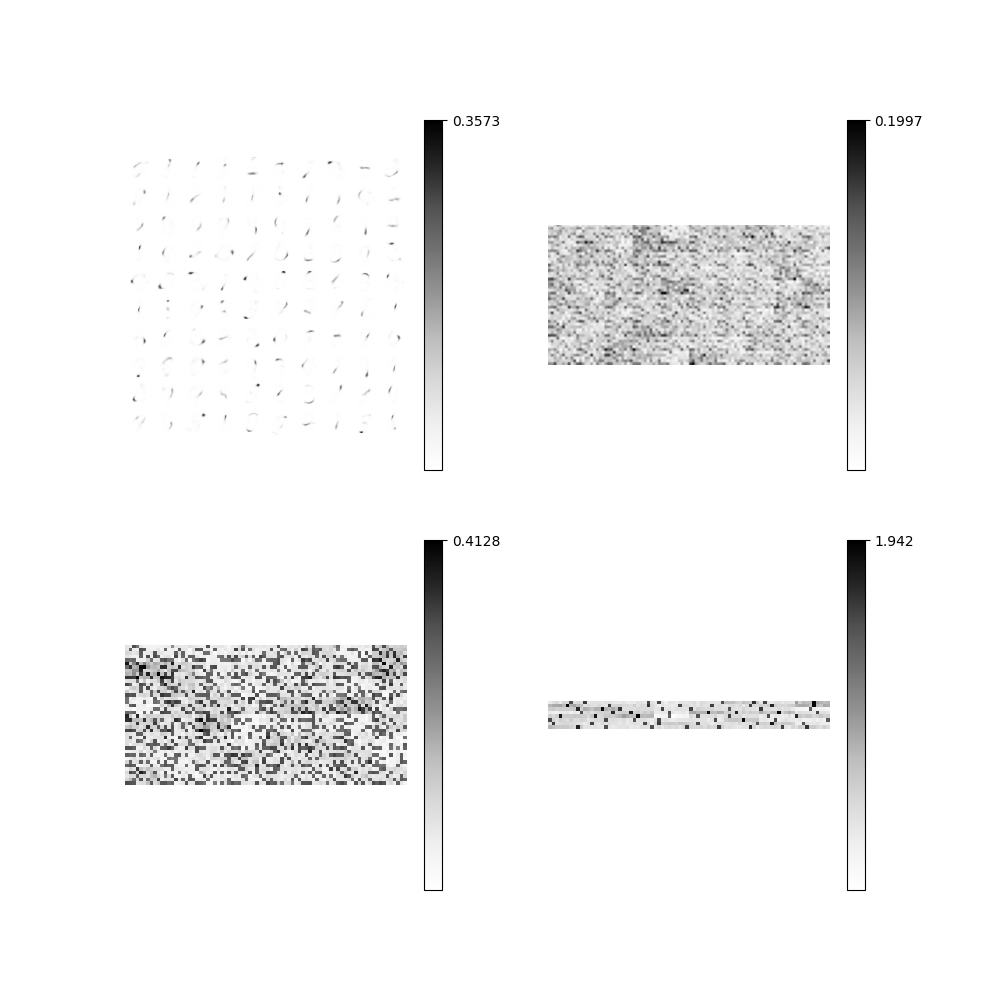

100%|██████████| 1000/1000 [00:07<00:00, 136.75it/s]


Accuracy:  0.064


100%|██████████| 1000/1000 [00:07<00:00, 138.64it/s]


Accuracy:  0.142


100%|██████████| 1000/1000 [00:07<00:00, 140.29it/s]


Accuracy:  0.144


100%|██████████| 1000/1000 [00:07<00:00, 139.19it/s]


Accuracy:  0.104


100%|██████████| 1000/1000 [00:07<00:00, 137.11it/s]


Accuracy:  0.102


100%|██████████| 1000/1000 [00:07<00:00, 138.98it/s]


Accuracy:  0.138


100%|██████████| 1000/1000 [00:07<00:00, 139.24it/s]


Accuracy:  0.096


100%|██████████| 1000/1000 [00:07<00:00, 135.43it/s]


Accuracy:  0.1


100%|██████████| 1000/1000 [00:07<00:00, 133.86it/s]


Accuracy:  0.118


100%|██████████| 1000/1000 [00:07<00:00, 136.72it/s]


Accuracy:  0.106


In [151]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))


m_len = 28 * 28 
tr_len = 60000


prec = 1e-10

# Sparse 1
S1x = 10
S1y = 10

NS1 = S1x * S1y

# Invariant
Ivx = 5
Ivy = 10
hw2 = 0.5

NIv = Ivx * Ivy

# Sparse 2
S2x = 8
S2y = 8
hw3 = 0.5 # How much we weight top-down vs bottom-up


NS2 = S2x * S2y

xi = 0.05


# In - Sparse 1
w1 = cp.random.uniform(0, 0.05, (NS1, m_len))
n_w1 = 15 #Number of winners

iv_b = (NS1 * NIv)
iv_t = (NS2 * NIv)

iv_syn = (iv_b) + (iv_t)
iv_init = 0.02


# Sparse 1 - Iv
w2 = cp.random.uniform(0, 0.1, (NS1, NIv))
n_w2 = n_w1 #Number of winners

# Iv - Sparse 2
w3 = cp.random.uniform(0, 0.5, (NS2, NIv))
n_w3 = 1

# Sparse 2 - Class
w4 = cp.random.uniform(0, 0.1, (NS2, 10))

# Count Passes
passthrough_count = 2 # How many times we go back and forth through the network
show_count = 4

debug = False
de2 = False

Nep = 10
T_s = 1000
hw1 = .5 # How much we weight top-down vs bottom-up

for ep in range(Nep):
    rand_pert = np.random.permutation(tr_len)
#     rand_pert = list(range(tr_len)) # JUST FOR DEBUGGING
    inputs = gp_ftr[rand_pert]
    outputs = gp_cr[rand_pert]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        cl = outputs[i].reshape(-1, 1)

        s1_bottom = cp.zeros((NS1, 1))
        s1_top = cp.zeros((NS1, 1))
        
        iv_bottom = cp.zeros((NIv, 1))
        iv_top = cp.zeros((NIv, 1))
        
        s2_bottom = cp.zeros((NS2, 1))
        s2_top = cp.zeros((NS2, 1))
        
        
        def calc_s1():
            global s1_bottom, s1_top
            
            s1_bottom = w1 @ v
            s1_top = w2 @ iv_bottom
            
            s1_comp = (hw1 * s1_bottom / cp.max(s1_bottom)) + ((1 - hw1) * s1_top / cp.max(s1_top))
            s1_winners = cp.argsort(s1_comp, axis=0)[-n_w1:]
            s1_top = cp.zeros((NS1, 1))
            s1_top[s1_winners] = 1
            s1_bottom *= s1_top
            
        def calc_iv():
            global iv_bottom, iv_top
            
            iv_bottom = w2.T @ s1_top
            iv_top = w3.T @ s2_bottom
            iv_comp = (hw2 * iv_bottom / cp.max(iv_bottom)) + ((1 - hw2) * iv_top / cp.max(iv_top))
            
            iv_winners = cp.argsort(iv_comp, axis=0)[-n_w2:]
            iv_top = cp.zeros((NIv, 1))
            iv_top[iv_winners] = 1
            iv_bottom = iv_top
            
        def calc_s2():
            global s2_bottom, s2_top
            
            s2_bottom = w3 @ iv_top
            s2_top = w4 @ cl
            s2_comp = (hw3 * s2_bottom / cp.max(s2_bottom)) + ((1 - hw3) * s2_top / cp.max(s2_top))
            
            s2_winners = cp.argsort(s2_comp, axis=0)[-n_w3:]
            s2_top = cp.zeros((NS2, 1))
            s2_top[s2_winners] = 1
            s2_bottom *= s2_top
            
        
        for _ in range(passthrough_count): 
            calc_s1()
            calc_iv()
            calc_s2()
            calc_iv()
        
        
        r1 = w1.T @ s1_bottom
        mod_r1 = cp.maximum(r1, prec)
        e1 = v - r1

        
        cc1 = w1 * s1_bottom * (e1 / mod_r1).T * xi
        w1 += cc1        
                
        r2 = w2.T @ s1_top
        mod_r2 = cp.maximum(r2, prec)
        e2 = iv_bottom - r2
        
        w2 += w2 * s1_top * (e2 / mod_r2).T * xi
                
        r3 = w3.T @ s2_bottom
        mod_r3 = cp.maximum(r3, prec)
        e3 = iv_top - r3
        
        w3 += w3 * s2_bottom * (e3 / mod_r3).T * xi
            
        r4 = w4.T @ s2_top
        mod_r4 = cp.maximum(r4, prec)
        e4 = cl - r4
        
        w4 += w4 * s2_top * (e4 / mod_r4).T * xi
        
        if i % 50 == 0:
            w1 += cp.random.uniform(0, 0.001, (NS1, m_len))
            w2 += cp.random.uniform(0, 0.05, (NS1, NIv))
            w3 += cp.random.uniform(0, 0.05, (NS2, NIv))
            w4 += cp.random.uniform(0, 0.05, (NS2, 10))
        
    draw_higher_order_weights(fig)
    accuracy(500)

Somehow that was worse... Interesting thought...

<IPython.core.display.Javascript object>


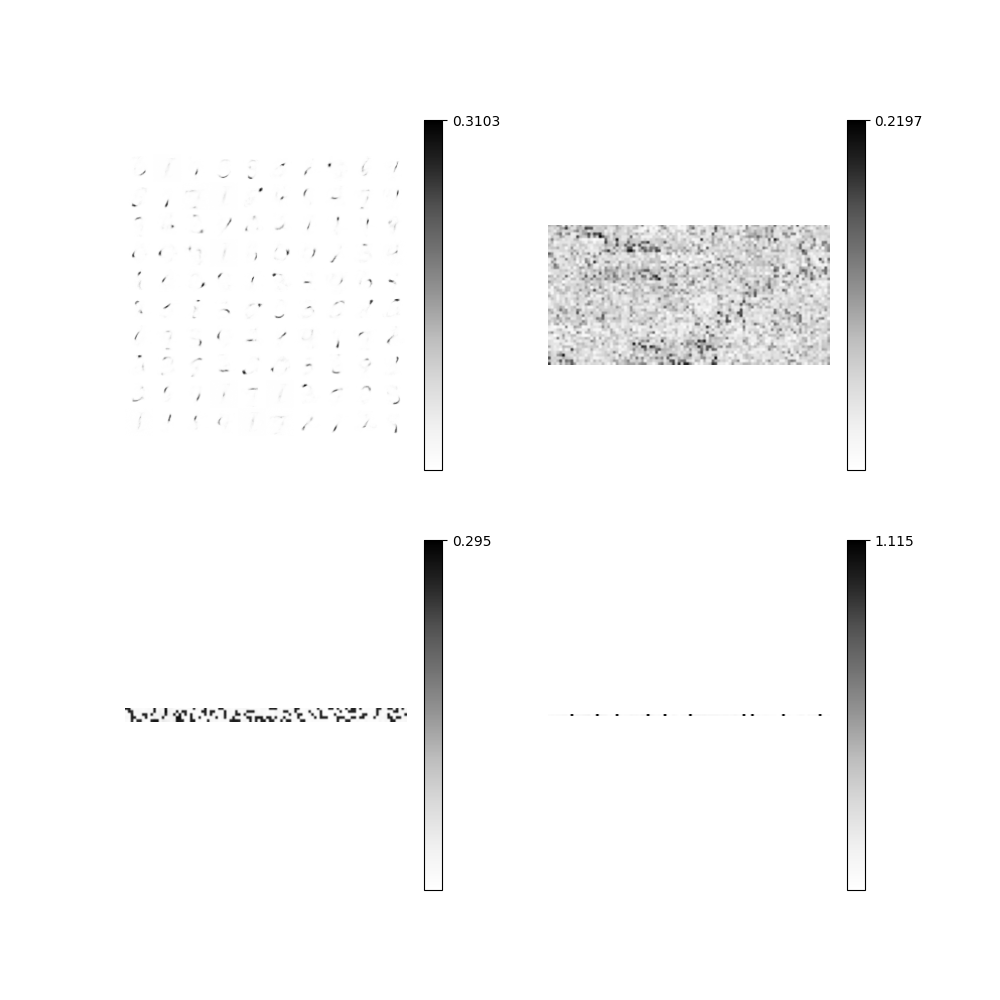

100%|██████████| 1000/1000 [00:07<00:00, 137.76it/s]


Accuracy:  0.636


100%|██████████| 1000/1000 [00:07<00:00, 139.20it/s]


Accuracy:  0.52


100%|██████████| 1000/1000 [00:07<00:00, 141.24it/s]


Accuracy:  0.608


100%|██████████| 1000/1000 [00:07<00:00, 136.70it/s]


Accuracy:  0.536


100%|██████████| 1000/1000 [00:07<00:00, 136.67it/s]


Accuracy:  0.578


100%|██████████| 1000/1000 [00:07<00:00, 140.35it/s]


Accuracy:  0.578


100%|██████████| 1000/1000 [00:07<00:00, 139.52it/s]


Accuracy:  0.54


 61%|██████▏   | 613/1000 [00:04<00:02, 133.08it/s]


KeyboardInterrupt: 

In [152]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))


m_len = 28 * 28 
tr_len = 60000


prec = 1e-10

# Sparse 1
S1x = 10
S1y = 10

NS1 = S1x * S1y

# Invariant
Ivx = 5
Ivy = 10
hw2 = 0.5

NIv = Ivx * Ivy

# Sparse 2
S2x = 10
S2y = 1
hw3 = 0.5 # How much we weight top-down vs bottom-up


NS2 = S2x * S2y

xi = 0.05


# In - Sparse 1
w1 = cp.random.uniform(0, 0.05, (NS1, m_len))
n_w1 = 15 #Number of winners

iv_b = (NS1 * NIv)
iv_t = (NS2 * NIv)

iv_syn = (iv_b) + (iv_t)
iv_init = 0.02


# Sparse 1 - Iv
w2 = cp.random.uniform(0, 0.1, (NS1, NIv))
n_w2 = n_w1 #Number of winners

# Iv - Sparse 2
w3 = cp.random.uniform(0, 0.5, (NS2, NIv))
n_w3 = 1

# Sparse 2 - Class
w4 = cp.random.uniform(0, 0.1, (NS2, 10))

# Count Passes
passthrough_count = 2 # How many times we go back and forth through the network
show_count = 4

debug = False
de2 = False

Nep = 10
T_s = 1000
hw1 = .5 # How much we weight top-down vs bottom-up

for ep in range(Nep):
    rand_pert = np.random.permutation(tr_len)
#     rand_pert = list(range(tr_len)) # JUST FOR DEBUGGING
    inputs = gp_ftr[rand_pert]
    outputs = gp_cr[rand_pert]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        cl = outputs[i].reshape(-1, 1)

        s1_bottom = cp.zeros((NS1, 1))
        s1_top = cp.zeros((NS1, 1))
        
        iv_bottom = cp.zeros((NIv, 1))
        iv_top = cp.zeros((NIv, 1))
        
        s2_bottom = cp.zeros((NS2, 1))
        s2_top = cp.zeros((NS2, 1))
        
        
        def calc_s1():
            global s1_bottom, s1_top
            
            s1_bottom = w1 @ v
            s1_top = w2 @ iv_bottom
            
            s1_comp = (hw1 * s1_bottom / cp.max(s1_bottom)) + ((1 - hw1) * s1_top / cp.max(s1_top))
            s1_winners = cp.argsort(s1_comp, axis=0)[-n_w1:]
            s1_top = cp.zeros((NS1, 1))
            s1_top[s1_winners] = 1
            s1_bottom *= s1_top
            
        def calc_iv():
            global iv_bottom, iv_top
            
            iv_bottom = w2.T @ s1_top
            iv_top = w3.T @ s2_bottom
            iv_comp = (hw2 * iv_bottom / cp.max(iv_bottom)) + ((1 - hw2) * iv_top / cp.max(iv_top))
            
            iv_winners = cp.argsort(iv_comp, axis=0)[-n_w2:]
            iv_top = cp.zeros((NIv, 1))
            iv_top[iv_winners] = 1
            iv_bottom = iv_top
            
        def calc_s2():
            global s2_bottom, s2_top
            
            s2_bottom = w3 @ iv_top
            s2_top = w4 @ cl
            s2_comp = (hw3 * s2_bottom / cp.max(s2_bottom)) + ((1 - hw3) * s2_top / cp.max(s2_top))
            
            s2_winners = cp.argsort(s2_comp, axis=0)[-n_w3:]
            s2_top = cp.zeros((NS2, 1))
            s2_top[s2_winners] = 1
            s2_bottom *= s2_top
            
        
        for _ in range(passthrough_count): 
            calc_s1()
            calc_iv()
            calc_s2()
            calc_iv()
        
        
        r1 = w1.T @ s1_bottom
        mod_r1 = cp.maximum(r1, prec)
        e1 = v - r1

        
        cc1 = w1 * s1_bottom * (e1 / mod_r1).T * xi
        w1 += cc1        
                
        r2 = w2.T @ s1_top
        mod_r2 = cp.maximum(r2, prec)
        e2 = iv_bottom - r2
        
        w2 += w2 * s1_top * (e2 / mod_r2).T * xi
                
        r3 = w3.T @ s2_bottom
        mod_r3 = cp.maximum(r3, prec)
        e3 = iv_top - r3
        
        w3 += w3 * s2_bottom * (e3 / mod_r3).T * xi
            
        r4 = w4.T @ s2_top
        mod_r4 = cp.maximum(r4, prec)
        e4 = cl - r4
        
        w4 += w4 * s2_top * (e4 / mod_r4).T * xi
        
        if i % 50 == 0:
            w1 += cp.random.uniform(0, 0.001, (NS1, m_len))
            w2 += cp.random.uniform(0, 0.05, (NS1, NIv))
            w3 += cp.random.uniform(0, 0.05, (NS2, NIv))
            w4 += cp.random.uniform(0, 0.05, (NS2, 10))
        
    draw_higher_order_weights(fig)
    accuracy(500)

<IPython.core.display.Javascript object>


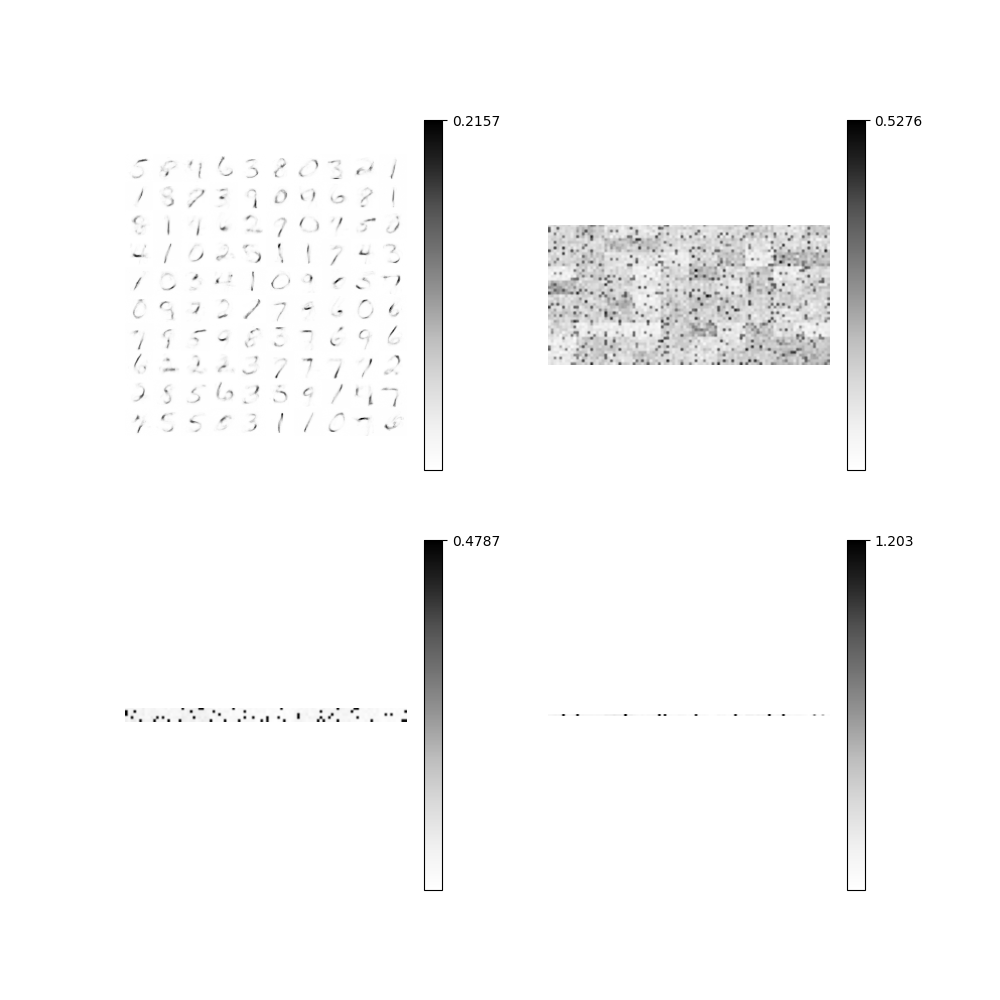

100%|██████████| 1000/1000 [00:07<00:00, 136.43it/s]


Accuracy:  0.72


100%|██████████| 1000/1000 [00:07<00:00, 137.00it/s]


Accuracy:  0.736


100%|██████████| 1000/1000 [00:07<00:00, 135.66it/s]


Accuracy:  0.72


100%|██████████| 1000/1000 [00:10<00:00, 95.53it/s]


Accuracy:  0.726


100%|██████████| 1000/1000 [00:07<00:00, 126.22it/s]


Accuracy:  0.682


100%|██████████| 1000/1000 [00:07<00:00, 132.25it/s]


Accuracy:  0.712


100%|██████████| 1000/1000 [00:07<00:00, 136.89it/s]


Accuracy:  0.724


100%|██████████| 1000/1000 [00:07<00:00, 131.86it/s]


Accuracy:  0.704


100%|██████████| 1000/1000 [00:10<00:00, 93.67it/s]


Accuracy:  0.722


100%|██████████| 1000/1000 [00:11<00:00, 85.22it/s]


Accuracy:  0.664


In [153]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))


m_len = 28 * 28 
tr_len = 60000


prec = 1e-10

# Sparse 1
S1x = 10
S1y = 10

NS1 = S1x * S1y

# Invariant
Ivx = 5
Ivy = 10
hw2 = 0.5

NIv = Ivx * Ivy

# Sparse 2
S2x = 10
S2y = 1
hw3 = 0.5 # How much we weight top-down vs bottom-up


NS2 = S2x * S2y

xi = 0.05


# In - Sparse 1
w1 = cp.random.uniform(0, 0.05, (NS1, m_len))
n_w1 = 5 #Number of winners

iv_b = (NS1 * NIv)
iv_t = (NS2 * NIv)

iv_syn = (iv_b) + (iv_t)
iv_init = 0.02


# Sparse 1 - Iv
w2 = cp.random.uniform(0, 0.1, (NS1, NIv))
n_w2 = n_w1 #Number of winners

# Iv - Sparse 2
w3 = cp.random.uniform(0, 0.5, (NS2, NIv))
n_w3 = 1

# Sparse 2 - Class
w4 = cp.random.uniform(0, 0.1, (NS2, 10))

# Count Passes
passthrough_count = 2 # How many times we go back and forth through the network
show_count = 4

debug = False
de2 = False

Nep = 10
T_s = 1000
hw1 = .5 # How much we weight top-down vs bottom-up

for ep in range(Nep):
    rand_pert = np.random.permutation(tr_len)
#     rand_pert = list(range(tr_len)) # JUST FOR DEBUGGING
    inputs = gp_ftr[rand_pert]
    outputs = gp_cr[rand_pert]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        cl = outputs[i].reshape(-1, 1)

        s1_bottom = cp.zeros((NS1, 1))
        s1_top = cp.zeros((NS1, 1))
        
        iv_bottom = cp.zeros((NIv, 1))
        iv_top = cp.zeros((NIv, 1))
        
        s2_bottom = cp.zeros((NS2, 1))
        s2_top = cp.zeros((NS2, 1))
        
        
        def calc_s1():
            global s1_bottom, s1_top
            
            s1_bottom = w1 @ v
            s1_top = w2 @ iv_bottom
            
            s1_comp = (hw1 * s1_bottom / cp.max(s1_bottom)) + ((1 - hw1) * s1_top / cp.max(s1_top))
            s1_winners = cp.argsort(s1_comp, axis=0)[-n_w1:]
            s1_top = cp.zeros((NS1, 1))
            s1_top[s1_winners] = 1
            s1_bottom *= s1_top
            
        def calc_iv():
            global iv_bottom, iv_top
            
            iv_bottom = w2.T @ s1_top
            iv_top = w3.T @ s2_bottom
            iv_comp = (hw2 * iv_bottom / cp.max(iv_bottom)) + ((1 - hw2) * iv_top / cp.max(iv_top))
            
            iv_winners = cp.argsort(iv_comp, axis=0)[-n_w2:]
            iv_top = cp.zeros((NIv, 1))
            iv_top[iv_winners] = 1
            iv_bottom = iv_top
            
        def calc_s2():
            global s2_bottom, s2_top
            
            s2_bottom = w3 @ iv_top
            s2_top = w4 @ cl
            s2_comp = (hw3 * s2_bottom / cp.max(s2_bottom)) + ((1 - hw3) * s2_top / cp.max(s2_top))
            
            s2_winners = cp.argsort(s2_comp, axis=0)[-n_w3:]
            s2_top = cp.zeros((NS2, 1))
            s2_top[s2_winners] = 1
            s2_bottom *= s2_top
            
        
        for _ in range(passthrough_count): 
            calc_s1()
            calc_iv()
            calc_s2()
            calc_iv()
        
        
        r1 = w1.T @ s1_bottom
        mod_r1 = cp.maximum(r1, prec)
        e1 = v - r1

        
        cc1 = w1 * s1_bottom * (e1 / mod_r1).T * xi
        w1 += cc1        
                
        r2 = w2.T @ s1_top
        mod_r2 = cp.maximum(r2, prec)
        e2 = iv_bottom - r2
        
        w2 += w2 * s1_top * (e2 / mod_r2).T * xi
                
        r3 = w3.T @ s2_bottom
        mod_r3 = cp.maximum(r3, prec)
        e3 = iv_top - r3
        
        w3 += w3 * s2_bottom * (e3 / mod_r3).T * xi
            
        r4 = w4.T @ s2_top
        mod_r4 = cp.maximum(r4, prec)
        e4 = cl - r4
        
        w4 += w4 * s2_top * (e4 / mod_r4).T * xi
        
        if i % 50 == 0:
            w1 += cp.random.uniform(0, 0.001, (NS1, m_len))
            w2 += cp.random.uniform(0, 0.05, (NS1, NIv))
            w3 += cp.random.uniform(0, 0.05, (NS2, NIv))
            w4 += cp.random.uniform(0, 0.05, (NS2, 10))
        
    draw_higher_order_weights(fig)
    accuracy(500)

<IPython.core.display.Javascript object>


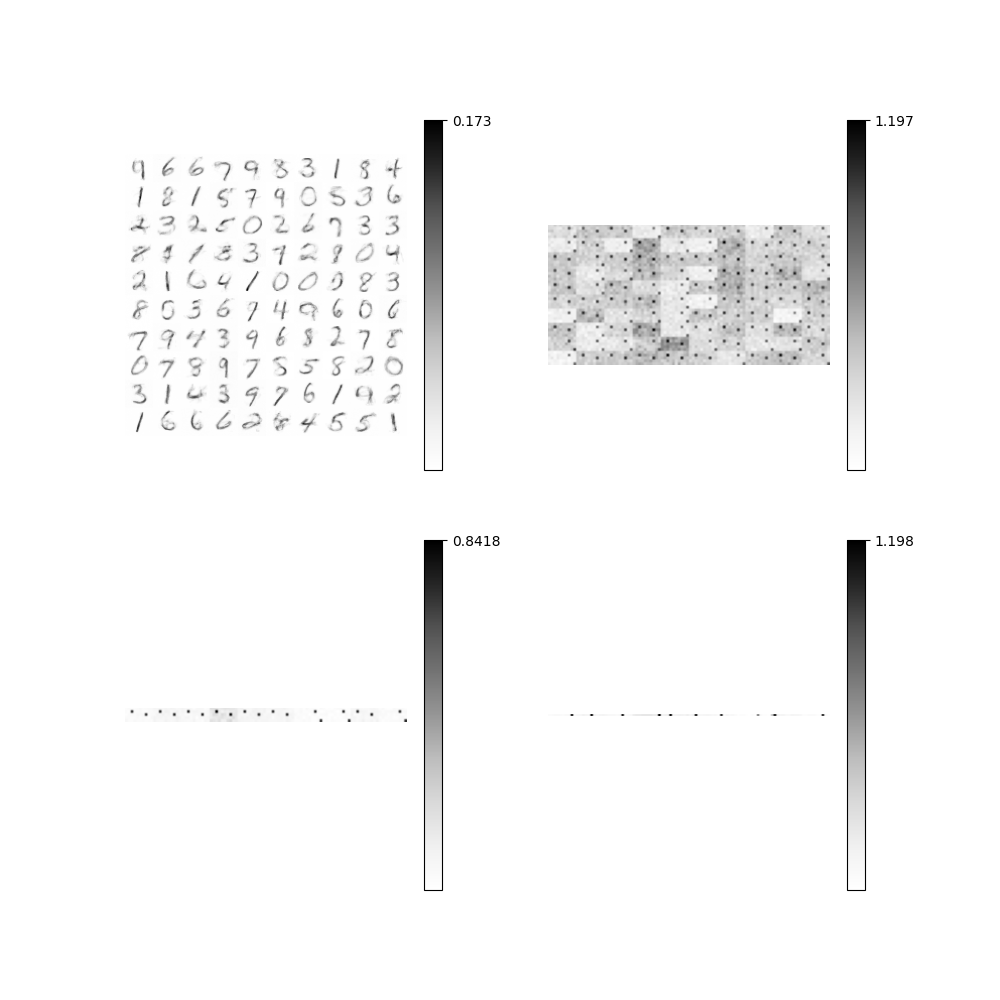

100%|██████████| 1000/1000 [00:07<00:00, 137.89it/s]


Accuracy:  0.104


100%|██████████| 1000/1000 [00:07<00:00, 137.62it/s]


Accuracy:  0.158


100%|██████████| 1000/1000 [00:07<00:00, 136.75it/s]


Accuracy:  0.17


100%|██████████| 1000/1000 [00:07<00:00, 137.41it/s]


Accuracy:  0.216


100%|██████████| 1000/1000 [00:07<00:00, 133.81it/s]


Accuracy:  0.204


100%|██████████| 1000/1000 [00:07<00:00, 137.47it/s]


Accuracy:  0.144


100%|██████████| 1000/1000 [00:08<00:00, 116.96it/s]


Accuracy:  0.116


100%|██████████| 1000/1000 [00:11<00:00, 87.56it/s]


Accuracy:  0.12


100%|██████████| 1000/1000 [00:11<00:00, 88.85it/s]


Accuracy:  0.09


100%|██████████| 1000/1000 [00:11<00:00, 88.73it/s]


Accuracy:  0.15


In [154]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))


m_len = 28 * 28 
tr_len = 60000


prec = 1e-10

# Sparse 1
S1x = 10
S1y = 10

NS1 = S1x * S1y

# Invariant
Ivx = 5
Ivy = 10
hw2 = 0.5

NIv = Ivx * Ivy

# Sparse 2
S2x = 10
S2y = 1
hw3 = 0.5 # How much we weight top-down vs bottom-up


NS2 = S2x * S2y

xi = 0.05


# In - Sparse 1
w1 = cp.random.uniform(0, 0.05, (NS1, m_len))
n_w1 = 2 #Number of winners

iv_b = (NS1 * NIv)
iv_t = (NS2 * NIv)

iv_syn = (iv_b) + (iv_t)
iv_init = 0.02


# Sparse 1 - Iv
w2 = cp.random.uniform(0, 0.1, (NS1, NIv))
n_w2 = n_w1 #Number of winners

# Iv - Sparse 2
w3 = cp.random.uniform(0, 0.5, (NS2, NIv))
n_w3 = 1

# Sparse 2 - Class
w4 = cp.random.uniform(0, 0.1, (NS2, 10))

# Count Passes
passthrough_count = 2 # How many times we go back and forth through the network
show_count = 4

debug = False
de2 = False

Nep = 10
T_s = 1000
hw1 = .5 # How much we weight top-down vs bottom-up

for ep in range(Nep):
    rand_pert = np.random.permutation(tr_len)
#     rand_pert = list(range(tr_len)) # JUST FOR DEBUGGING
    inputs = gp_ftr[rand_pert]
    outputs = gp_cr[rand_pert]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        cl = outputs[i].reshape(-1, 1)

        s1_bottom = cp.zeros((NS1, 1))
        s1_top = cp.zeros((NS1, 1))
        
        iv_bottom = cp.zeros((NIv, 1))
        iv_top = cp.zeros((NIv, 1))
        
        s2_bottom = cp.zeros((NS2, 1))
        s2_top = cp.zeros((NS2, 1))
        
        
        def calc_s1():
            global s1_bottom, s1_top
            
            s1_bottom = w1 @ v
            s1_top = w2 @ iv_bottom
            
            s1_comp = (hw1 * s1_bottom / cp.max(s1_bottom)) + ((1 - hw1) * s1_top / cp.max(s1_top))
            s1_winners = cp.argsort(s1_comp, axis=0)[-n_w1:]
            s1_top = cp.zeros((NS1, 1))
            s1_top[s1_winners] = 1
            s1_bottom *= s1_top
            
        def calc_iv():
            global iv_bottom, iv_top
            
            iv_bottom = w2.T @ s1_top
            iv_top = w3.T @ s2_bottom
            iv_comp = (hw2 * iv_bottom / cp.max(iv_bottom)) + ((1 - hw2) * iv_top / cp.max(iv_top))
            
            iv_winners = cp.argsort(iv_comp, axis=0)[-n_w2:]
            iv_top = cp.zeros((NIv, 1))
            iv_top[iv_winners] = 1
            iv_bottom = iv_top
            
        def calc_s2():
            global s2_bottom, s2_top
            
            s2_bottom = w3 @ iv_top
            s2_top = w4 @ cl
            s2_comp = (hw3 * s2_bottom / cp.max(s2_bottom)) + ((1 - hw3) * s2_top / cp.max(s2_top))
            
            s2_winners = cp.argsort(s2_comp, axis=0)[-n_w3:]
            s2_top = cp.zeros((NS2, 1))
            s2_top[s2_winners] = 1
            s2_bottom *= s2_top
            
        
        for _ in range(passthrough_count): 
            calc_s1()
            calc_iv()
            calc_s2()
            calc_iv()
        
        
        r1 = w1.T @ s1_bottom
        mod_r1 = cp.maximum(r1, prec)
        e1 = v - r1

        
        cc1 = w1 * s1_bottom * (e1 / mod_r1).T * xi
        w1 += cc1        
                
        r2 = w2.T @ s1_top
        mod_r2 = cp.maximum(r2, prec)
        e2 = iv_bottom - r2
        
        w2 += w2 * s1_top * (e2 / mod_r2).T * xi
                
        r3 = w3.T @ s2_bottom
        mod_r3 = cp.maximum(r3, prec)
        e3 = iv_top - r3
        
        w3 += w3 * s2_bottom * (e3 / mod_r3).T * xi
            
        r4 = w4.T @ s2_top
        mod_r4 = cp.maximum(r4, prec)
        e4 = cl - r4
        
        w4 += w4 * s2_top * (e4 / mod_r4).T * xi
        
        if i % 50 == 0:
            w1 += cp.random.uniform(0, 0.001, (NS1, m_len))
            w2 += cp.random.uniform(0, 0.05, (NS1, NIv))
            w3 += cp.random.uniform(0, 0.05, (NS2, NIv))
            w4 += cp.random.uniform(0, 0.05, (NS2, 10))
        
    draw_higher_order_weights(fig)
    accuracy(500)

Interesting.  So that's worse...

<IPython.core.display.Javascript object>


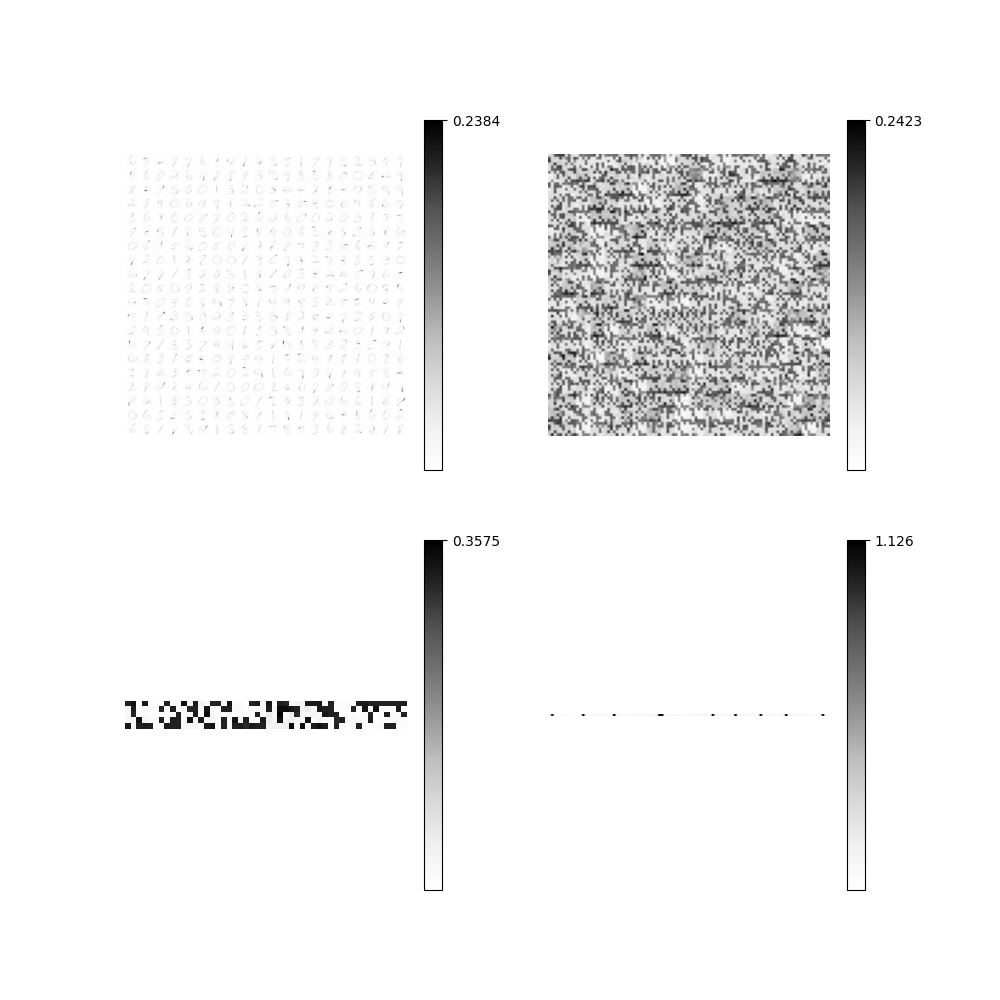

100%|██████████| 1000/1000 [00:12<00:00, 81.46it/s]


Accuracy:  0.788


100%|██████████| 1000/1000 [00:12<00:00, 81.38it/s]


Accuracy:  0.862


100%|██████████| 1000/1000 [00:10<00:00, 97.33it/s]


Accuracy:  0.844


100%|██████████| 1000/1000 [00:08<00:00, 122.46it/s]


Accuracy:  0.842


100%|██████████| 1000/1000 [00:12<00:00, 79.54it/s]


Accuracy:  0.844


 21%|██▏       | 213/1000 [00:02<00:10, 73.78it/s]


KeyboardInterrupt: 

In [158]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))


m_len = 28 * 28 
tr_len = 60000


prec = 1e-10

# Sparse 1
S1x = 20
S1y = 20

NS1 = S1x * S1y

# Invariant
Ivx = 5
Ivy = 5
hw2 = 0.5

NIv = Ivx * Ivy

# Sparse 2
S2x = 10
S2y = 1
hw3 = 0.5 # How much we weight top-down vs bottom-up


NS2 = S2x * S2y

xi = 0.05


# In - Sparse 1
w1 = cp.random.uniform(0, 0.05, (NS1, m_len))
n_w1 = 10 #Number of winners

iv_b = (NS1 * NIv)
iv_t = (NS2 * NIv)

iv_syn = (iv_b) + (iv_t)
iv_init = 0.02


# Sparse 1 - Iv
w2 = cp.random.uniform(0, 0.1, (NS1, NIv))
n_w2 = n_w1 #Number of winners

# Iv - Sparse 2
w3 = cp.random.uniform(0, 0.5, (NS2, NIv))
n_w3 = 1

# Sparse 2 - Class
w4 = cp.random.uniform(0, 0.1, (NS2, 10))

# Count Passes
passthrough_count = 2 # How many times we go back and forth through the network
show_count = 4

debug = False
de2 = False

Nep = 10
T_s = 1000
hw1 = .5 # How much we weight top-down vs bottom-up

for ep in range(Nep):
    rand_pert = np.random.permutation(tr_len)
#     rand_pert = list(range(tr_len)) # JUST FOR DEBUGGING
    inputs = gp_ftr[rand_pert]
    outputs = gp_cr[rand_pert]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        cl = outputs[i].reshape(-1, 1)

        s1_bottom = cp.zeros((NS1, 1))
        s1_top = cp.zeros((NS1, 1))
        
        iv_bottom = cp.zeros((NIv, 1))
        iv_top = cp.zeros((NIv, 1))
        
        s2_bottom = cp.zeros((NS2, 1))
        s2_top = cp.zeros((NS2, 1))
        
        
        def calc_s1():
            global s1_bottom, s1_top
            
            s1_bottom = w1 @ v
            s1_top = w2 @ iv_bottom
            
            s1_comp = (hw1 * s1_bottom / cp.max(s1_bottom)) + ((1 - hw1) * s1_top / cp.max(s1_top))
            s1_winners = cp.argsort(s1_comp, axis=0)[-n_w1:]
            s1_top = cp.zeros((NS1, 1))
            s1_top[s1_winners] = 1
            s1_bottom *= s1_top
            
        def calc_iv():
            global iv_bottom, iv_top
            
            iv_bottom = w2.T @ s1_top
            iv_top = w3.T @ s2_bottom
            iv_comp = (hw2 * iv_bottom / cp.max(iv_bottom)) + ((1 - hw2) * iv_top / cp.max(iv_top))
            
            iv_winners = cp.argsort(iv_comp, axis=0)[-n_w2:]
            iv_top = cp.zeros((NIv, 1))
            iv_top[iv_winners] = 1
            iv_bottom = iv_top
            
        def calc_s2():
            global s2_bottom, s2_top
            
            s2_bottom = w3 @ iv_top
            s2_top = w4 @ cl
            s2_comp = (hw3 * s2_bottom / cp.max(s2_bottom)) + ((1 - hw3) * s2_top / cp.max(s2_top))
            
            s2_winners = cp.argsort(s2_comp, axis=0)[-n_w3:]
            s2_top = cp.zeros((NS2, 1))
            s2_top[s2_winners] = 1
            s2_bottom *= s2_top
            
        
        for _ in range(passthrough_count): 
            calc_s1()
            calc_iv()
            calc_s2()
            calc_iv()
        
        
        r1 = w1.T @ s1_bottom
        mod_r1 = cp.maximum(r1, prec)
        e1 = v - r1

        
        cc1 = w1 * s1_bottom * (e1 / mod_r1).T * xi
        w1 += cc1        
                
        r2 = w2.T @ s1_top
        mod_r2 = cp.maximum(r2, prec)
        e2 = iv_bottom - r2
        
        w2 += w2 * s1_top * (e2 / mod_r2).T * xi
                
        r3 = w3.T @ s2_bottom
        mod_r3 = cp.maximum(r3, prec)
        e3 = iv_top - r3
        
        w3 += w3 * s2_bottom * (e3 / mod_r3).T * xi
            
        r4 = w4.T @ s2_top
        mod_r4 = cp.maximum(r4, prec)
        e4 = cl - r4
        
        w4 += w4 * s2_top * (e4 / mod_r4).T * xi
        
        if i % 50 == 0:
            w1 += cp.random.uniform(0, 0.001, (NS1, m_len))
            w2 += cp.random.uniform(0, 0.01, (NS1, NIv))
            w3 += cp.random.uniform(0, 0.05, (NS2, NIv))
            w4 += cp.random.uniform(0, 0.05, (NS2, 10))
        
    draw_higher_order_weights(fig)
    accuracy(500)

<IPython.core.display.Javascript object>


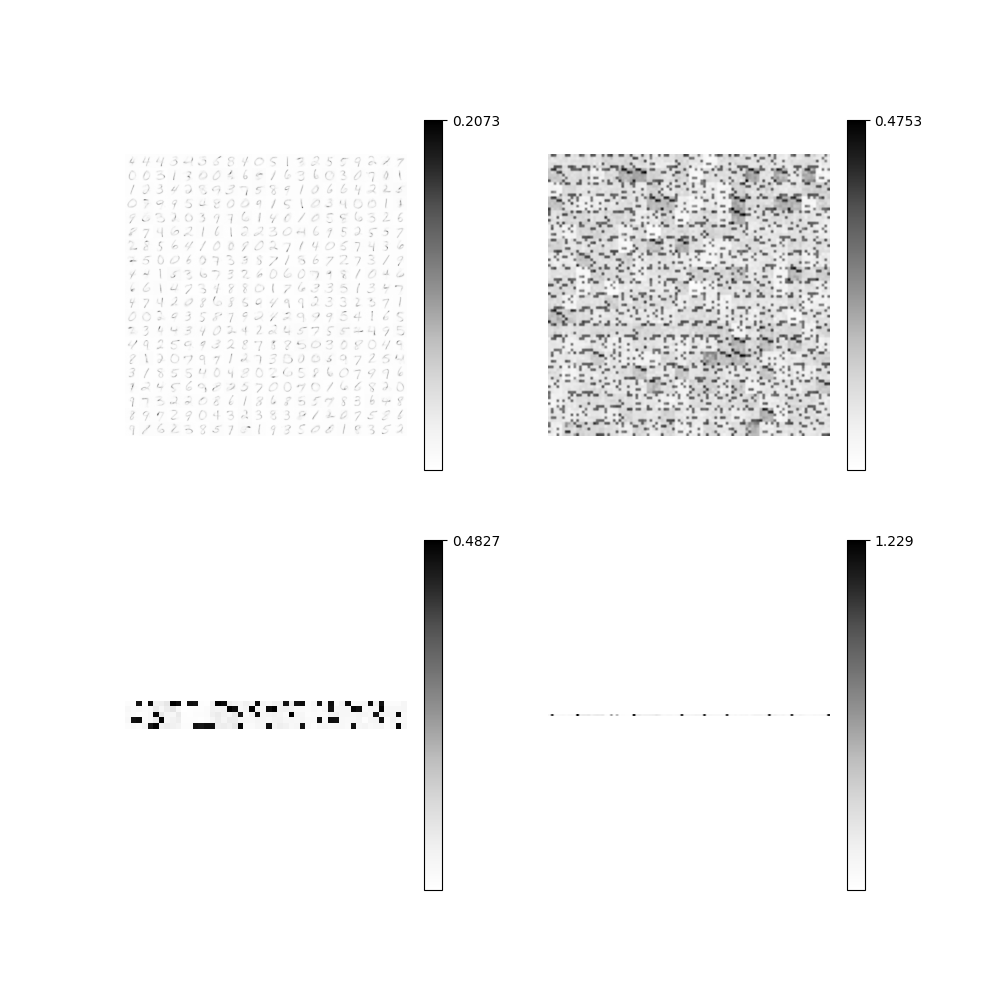

100%|██████████| 1000/1000 [00:07<00:00, 135.05it/s]


Accuracy:  0.372


100%|██████████| 1000/1000 [00:07<00:00, 138.85it/s]


Accuracy:  0.636


100%|██████████| 1000/1000 [00:07<00:00, 138.05it/s]


Accuracy:  0.698


100%|██████████| 1000/1000 [00:07<00:00, 135.00it/s]


Accuracy:  0.71


100%|██████████| 1000/1000 [00:07<00:00, 133.73it/s]


Accuracy:  0.704


100%|██████████| 1000/1000 [00:07<00:00, 136.74it/s]


Accuracy:  0.688


100%|██████████| 1000/1000 [00:10<00:00, 99.08it/s]


Accuracy:  0.684


100%|██████████| 1000/1000 [00:13<00:00, 76.45it/s]


Accuracy:  0.688


100%|██████████| 1000/1000 [00:12<00:00, 80.04it/s]


Accuracy:  0.712


100%|██████████| 1000/1000 [00:12<00:00, 81.25it/s]


Accuracy:  0.698


In [159]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))


m_len = 28 * 28 
tr_len = 60000


prec = 1e-10

# Sparse 1
S1x = 20
S1y = 20

NS1 = S1x * S1y

# Invariant
Ivx = 5
Ivy = 5
hw2 = 0.5

NIv = Ivx * Ivy

# Sparse 2
S2x = 10
S2y = 1
hw3 = 0.5 # How much we weight top-down vs bottom-up


NS2 = S2x * S2y

xi = 0.05


# In - Sparse 1
w1 = cp.random.uniform(0, 0.05, (NS1, m_len))
n_w1 = 5 #Number of winners

iv_b = (NS1 * NIv)
iv_t = (NS2 * NIv)

iv_syn = (iv_b) + (iv_t)
iv_init = 0.02


# Sparse 1 - Iv
w2 = cp.random.uniform(0, 0.1, (NS1, NIv))
n_w2 = n_w1 #Number of winners

# Iv - Sparse 2
w3 = cp.random.uniform(0, 0.5, (NS2, NIv))
n_w3 = 1

# Sparse 2 - Class
w4 = cp.random.uniform(0, 0.1, (NS2, 10))

# Count Passes
passthrough_count = 2 # How many times we go back and forth through the network
show_count = 4

debug = False
de2 = False

Nep = 10
T_s = 1000
hw1 = .5 # How much we weight top-down vs bottom-up

for ep in range(Nep):
    rand_pert = np.random.permutation(tr_len)
#     rand_pert = list(range(tr_len)) # JUST FOR DEBUGGING
    inputs = gp_ftr[rand_pert]
    outputs = gp_cr[rand_pert]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        cl = outputs[i].reshape(-1, 1)

        s1_bottom = cp.zeros((NS1, 1))
        s1_top = cp.zeros((NS1, 1))
        
        iv_bottom = cp.zeros((NIv, 1))
        iv_top = cp.zeros((NIv, 1))
        
        s2_bottom = cp.zeros((NS2, 1))
        s2_top = cp.zeros((NS2, 1))
        
        
        def calc_s1():
            global s1_bottom, s1_top
            
            s1_bottom = w1 @ v
            s1_top = w2 @ iv_bottom
            
            s1_comp = (hw1 * s1_bottom / cp.max(s1_bottom)) + ((1 - hw1) * s1_top / cp.max(s1_top))
            s1_winners = cp.argsort(s1_comp, axis=0)[-n_w1:]
            s1_top = cp.zeros((NS1, 1))
            s1_top[s1_winners] = 1
            s1_bottom *= s1_top
            
        def calc_iv():
            global iv_bottom, iv_top
            
            iv_bottom = w2.T @ s1_top
            iv_top = w3.T @ s2_bottom
            iv_comp = (hw2 * iv_bottom / cp.max(iv_bottom)) + ((1 - hw2) * iv_top / cp.max(iv_top))
            
            iv_winners = cp.argsort(iv_comp, axis=0)[-n_w2:]
            iv_top = cp.zeros((NIv, 1))
            iv_top[iv_winners] = 1
            iv_bottom = iv_top
            
        def calc_s2():
            global s2_bottom, s2_top
            
            s2_bottom = w3 @ iv_top
            s2_top = w4 @ cl
            s2_comp = (hw3 * s2_bottom / cp.max(s2_bottom)) + ((1 - hw3) * s2_top / cp.max(s2_top))
            
            s2_winners = cp.argsort(s2_comp, axis=0)[-n_w3:]
            s2_top = cp.zeros((NS2, 1))
            s2_top[s2_winners] = 1
            s2_bottom *= s2_top
            
        
        for _ in range(passthrough_count): 
            calc_s1()
            calc_iv()
            calc_s2()
            calc_iv()
        
        
        r1 = w1.T @ s1_bottom
        mod_r1 = cp.maximum(r1, prec)
        e1 = v - r1

        
        cc1 = w1 * s1_bottom * (e1 / mod_r1).T * xi
        w1 += cc1        
                
        r2 = w2.T @ s1_top
        mod_r2 = cp.maximum(r2, prec)
        e2 = iv_bottom - r2
        
        w2 += w2 * s1_top * (e2 / mod_r2).T * xi
                
        r3 = w3.T @ s2_bottom
        mod_r3 = cp.maximum(r3, prec)
        e3 = iv_top - r3
        
        w3 += w3 * s2_bottom * (e3 / mod_r3).T * xi
            
        r4 = w4.T @ s2_top
        mod_r4 = cp.maximum(r4, prec)
        e4 = cl - r4
        
        w4 += w4 * s2_top * (e4 / mod_r4).T * xi
        
        if i % 50 == 0:
            w1 += cp.random.uniform(0, 0.001, (NS1, m_len))
            w2 += cp.random.uniform(0, 0.01, (NS1, NIv))
            w3 += cp.random.uniform(0, 0.05, (NS2, NIv))
            w4 += cp.random.uniform(0, 0.05, (NS2, 10))
        
    draw_higher_order_weights(fig)
    accuracy(500)

I'm going to test this for different numbers of invariant neurons, see how that affects things.

<IPython.core.display.Javascript object>


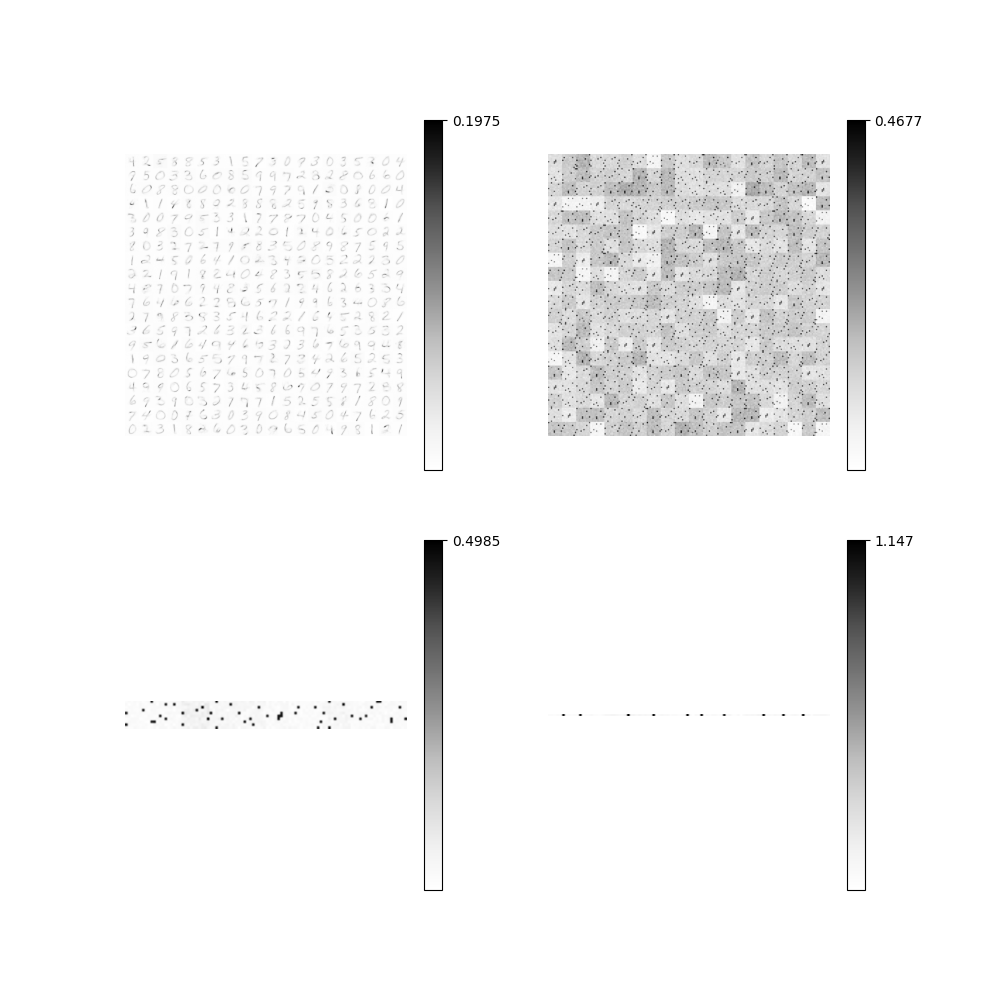

100%|██████████| 1000/1000 [00:07<00:00, 133.27it/s]


Accuracy:  0.402


100%|██████████| 1000/1000 [00:07<00:00, 136.03it/s]


Accuracy:  0.69


100%|██████████| 1000/1000 [00:07<00:00, 134.36it/s]


Accuracy:  0.778


100%|██████████| 1000/1000 [00:07<00:00, 133.81it/s]


Accuracy:  0.784


100%|██████████| 1000/1000 [00:08<00:00, 119.84it/s]


Accuracy:  0.796


100%|██████████| 1000/1000 [00:07<00:00, 125.98it/s]


Accuracy:  0.766


100%|██████████| 1000/1000 [00:07<00:00, 131.31it/s]


Accuracy:  0.792


100%|██████████| 1000/1000 [00:10<00:00, 97.87it/s]


Accuracy:  0.79


100%|██████████| 1000/1000 [00:12<00:00, 78.23it/s]


Accuracy:  0.768


100%|██████████| 1000/1000 [00:13<00:00, 76.14it/s]


Accuracy:  0.788


In [160]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))


m_len = 28 * 28 
tr_len = 60000


prec = 1e-10

# Sparse 1
S1x = 20
S1y = 20

NS1 = S1x * S1y

# Invariant
Ivx = 10
Ivy = 10
hw2 = 0.5

NIv = Ivx * Ivy

# Sparse 2
S2x = 10
S2y = 1
hw3 = 0.5 # How much we weight top-down vs bottom-up


NS2 = S2x * S2y

xi = 0.05


# In - Sparse 1
w1 = cp.random.uniform(0, 0.05, (NS1, m_len))
n_w1 = 5 #Number of winners

iv_b = (NS1 * NIv)
iv_t = (NS2 * NIv)

iv_syn = (iv_b) + (iv_t)
iv_init = 0.02


# Sparse 1 - Iv
w2 = cp.random.uniform(0, 0.1, (NS1, NIv))
n_w2 = n_w1 #Number of winners

# Iv - Sparse 2
w3 = cp.random.uniform(0, 0.5, (NS2, NIv))
n_w3 = 1

# Sparse 2 - Class
w4 = cp.random.uniform(0, 0.1, (NS2, 10))

# Count Passes
passthrough_count = 2 # How many times we go back and forth through the network
show_count = 4

debug = False
de2 = False

Nep = 10
T_s = 1000
hw1 = .5 # How much we weight top-down vs bottom-up

for ep in range(Nep):
    rand_pert = np.random.permutation(tr_len)
#     rand_pert = list(range(tr_len)) # JUST FOR DEBUGGING
    inputs = gp_ftr[rand_pert]
    outputs = gp_cr[rand_pert]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        cl = outputs[i].reshape(-1, 1)

        s1_bottom = cp.zeros((NS1, 1))
        s1_top = cp.zeros((NS1, 1))
        
        iv_bottom = cp.zeros((NIv, 1))
        iv_top = cp.zeros((NIv, 1))
        
        s2_bottom = cp.zeros((NS2, 1))
        s2_top = cp.zeros((NS2, 1))
        
        
        def calc_s1():
            global s1_bottom, s1_top
            
            s1_bottom = w1 @ v
            s1_top = w2 @ iv_bottom
            
            s1_comp = (hw1 * s1_bottom / cp.max(s1_bottom)) + ((1 - hw1) * s1_top / cp.max(s1_top))
            s1_winners = cp.argsort(s1_comp, axis=0)[-n_w1:]
            s1_top = cp.zeros((NS1, 1))
            s1_top[s1_winners] = 1
            s1_bottom *= s1_top
            
        def calc_iv():
            global iv_bottom, iv_top
            
            iv_bottom = w2.T @ s1_top
            iv_top = w3.T @ s2_bottom
            iv_comp = (hw2 * iv_bottom / cp.max(iv_bottom)) + ((1 - hw2) * iv_top / cp.max(iv_top))
            
            iv_winners = cp.argsort(iv_comp, axis=0)[-n_w2:]
            iv_top = cp.zeros((NIv, 1))
            iv_top[iv_winners] = 1
            iv_bottom = iv_top
            
        def calc_s2():
            global s2_bottom, s2_top
            
            s2_bottom = w3 @ iv_top
            s2_top = w4 @ cl
            s2_comp = (hw3 * s2_bottom / cp.max(s2_bottom)) + ((1 - hw3) * s2_top / cp.max(s2_top))
            
            s2_winners = cp.argsort(s2_comp, axis=0)[-n_w3:]
            s2_top = cp.zeros((NS2, 1))
            s2_top[s2_winners] = 1
            s2_bottom *= s2_top
            
        
        for _ in range(passthrough_count): 
            calc_s1()
            calc_iv()
            calc_s2()
            calc_iv()
        
        
        r1 = w1.T @ s1_bottom
        mod_r1 = cp.maximum(r1, prec)
        e1 = v - r1

        
        cc1 = w1 * s1_bottom * (e1 / mod_r1).T * xi
        w1 += cc1        
                
        r2 = w2.T @ s1_top
        mod_r2 = cp.maximum(r2, prec)
        e2 = iv_bottom - r2
        
        w2 += w2 * s1_top * (e2 / mod_r2).T * xi
                
        r3 = w3.T @ s2_bottom
        mod_r3 = cp.maximum(r3, prec)
        e3 = iv_top - r3
        
        w3 += w3 * s2_bottom * (e3 / mod_r3).T * xi
            
        r4 = w4.T @ s2_top
        mod_r4 = cp.maximum(r4, prec)
        e4 = cl - r4
        
        w4 += w4 * s2_top * (e4 / mod_r4).T * xi
        
        if i % 50 == 0:
            w1 += cp.random.uniform(0, 0.001, (NS1, m_len))
            w2 += cp.random.uniform(0, 0.01, (NS1, NIv))
            w3 += cp.random.uniform(0, 0.05, (NS2, NIv))
            w4 += cp.random.uniform(0, 0.05, (NS2, 10))
        
    draw_higher_order_weights(fig)
    accuracy(500)

<IPython.core.display.Javascript object>


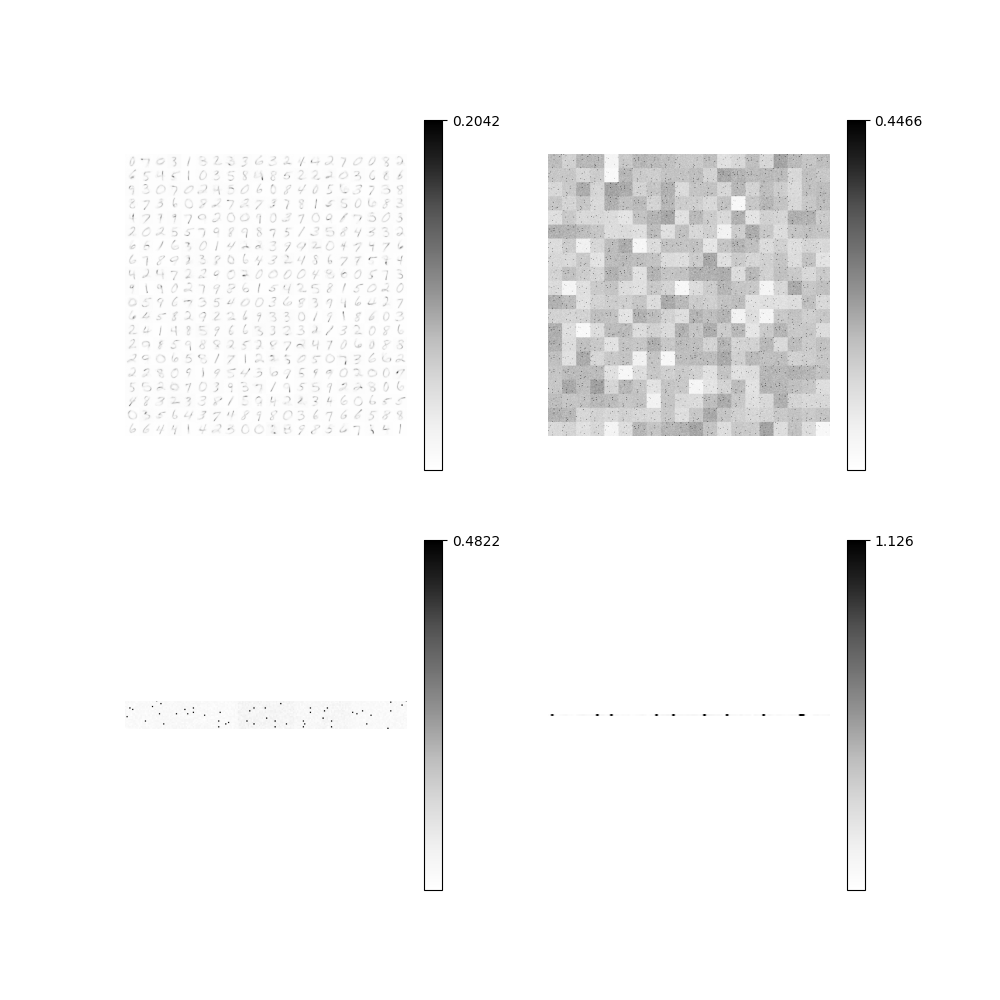

100%|██████████| 1000/1000 [00:07<00:00, 127.36it/s]


Accuracy:  0.446


100%|██████████| 1000/1000 [00:07<00:00, 127.53it/s]


Accuracy:  0.78


100%|██████████| 1000/1000 [00:07<00:00, 125.41it/s]


Accuracy:  0.852


100%|██████████| 1000/1000 [00:08<00:00, 124.03it/s]


Accuracy:  0.878


100%|██████████| 1000/1000 [00:08<00:00, 113.53it/s]


Accuracy:  0.88


100%|██████████| 1000/1000 [00:14<00:00, 69.16it/s]


Accuracy:  0.85


100%|██████████| 1000/1000 [00:14<00:00, 69.72it/s]


Accuracy:  0.864


100%|██████████| 1000/1000 [00:14<00:00, 69.66it/s]


Accuracy:  0.888


100%|██████████| 1000/1000 [00:14<00:00, 69.58it/s]


Accuracy:  0.876


 15%|█▍        | 146/1000 [00:02<00:12, 65.94it/s]


KeyboardInterrupt: 

In [161]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))


m_len = 28 * 28 
tr_len = 60000


prec = 1e-10

# Sparse 1
S1x = 20
S1y = 20

NS1 = S1x * S1y

# Invariant
Ivx = 20
Ivy = 20
hw2 = 0.5

NIv = Ivx * Ivy

# Sparse 2
S2x = 10
S2y = 1
hw3 = 0.5 # How much we weight top-down vs bottom-up


NS2 = S2x * S2y

xi = 0.05


# In - Sparse 1
w1 = cp.random.uniform(0, 0.05, (NS1, m_len))
n_w1 = 5 #Number of winners

iv_b = (NS1 * NIv)
iv_t = (NS2 * NIv)

iv_syn = (iv_b) + (iv_t)
iv_init = 0.02


# Sparse 1 - Iv
w2 = cp.random.uniform(0, 0.1, (NS1, NIv))
n_w2 = n_w1 #Number of winners

# Iv - Sparse 2
w3 = cp.random.uniform(0, 0.5, (NS2, NIv))
n_w3 = 1

# Sparse 2 - Class
w4 = cp.random.uniform(0, 0.1, (NS2, 10))

# Count Passes
passthrough_count = 2 # How many times we go back and forth through the network
show_count = 4

debug = False
de2 = False

Nep = 10
T_s = 1000
hw1 = .5 # How much we weight top-down vs bottom-up

for ep in range(Nep):
    rand_pert = np.random.permutation(tr_len)
#     rand_pert = list(range(tr_len)) # JUST FOR DEBUGGING
    inputs = gp_ftr[rand_pert]
    outputs = gp_cr[rand_pert]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        cl = outputs[i].reshape(-1, 1)

        s1_bottom = cp.zeros((NS1, 1))
        s1_top = cp.zeros((NS1, 1))
        
        iv_bottom = cp.zeros((NIv, 1))
        iv_top = cp.zeros((NIv, 1))
        
        s2_bottom = cp.zeros((NS2, 1))
        s2_top = cp.zeros((NS2, 1))
        
        
        def calc_s1():
            global s1_bottom, s1_top
            
            s1_bottom = w1 @ v
            s1_top = w2 @ iv_bottom
            
            s1_comp = (hw1 * s1_bottom / cp.max(s1_bottom)) + ((1 - hw1) * s1_top / cp.max(s1_top))
            s1_winners = cp.argsort(s1_comp, axis=0)[-n_w1:]
            s1_top = cp.zeros((NS1, 1))
            s1_top[s1_winners] = 1
            s1_bottom *= s1_top
            
        def calc_iv():
            global iv_bottom, iv_top
            
            iv_bottom = w2.T @ s1_top
            iv_top = w3.T @ s2_bottom
            iv_comp = (hw2 * iv_bottom / cp.max(iv_bottom)) + ((1 - hw2) * iv_top / cp.max(iv_top))
            
            iv_winners = cp.argsort(iv_comp, axis=0)[-n_w2:]
            iv_top = cp.zeros((NIv, 1))
            iv_top[iv_winners] = 1
            iv_bottom = iv_top
            
        def calc_s2():
            global s2_bottom, s2_top
            
            s2_bottom = w3 @ iv_top
            s2_top = w4 @ cl
            s2_comp = (hw3 * s2_bottom / cp.max(s2_bottom)) + ((1 - hw3) * s2_top / cp.max(s2_top))
            
            s2_winners = cp.argsort(s2_comp, axis=0)[-n_w3:]
            s2_top = cp.zeros((NS2, 1))
            s2_top[s2_winners] = 1
            s2_bottom *= s2_top
            
        
        for _ in range(passthrough_count): 
            calc_s1()
            calc_iv()
            calc_s2()
            calc_iv()
        
        
        r1 = w1.T @ s1_bottom
        mod_r1 = cp.maximum(r1, prec)
        e1 = v - r1

        
        cc1 = w1 * s1_bottom * (e1 / mod_r1).T * xi
        w1 += cc1        
                
        r2 = w2.T @ s1_top
        mod_r2 = cp.maximum(r2, prec)
        e2 = iv_bottom - r2
        
        w2 += w2 * s1_top * (e2 / mod_r2).T * xi
                
        r3 = w3.T @ s2_bottom
        mod_r3 = cp.maximum(r3, prec)
        e3 = iv_top - r3
        
        w3 += w3 * s2_bottom * (e3 / mod_r3).T * xi
            
        r4 = w4.T @ s2_top
        mod_r4 = cp.maximum(r4, prec)
        e4 = cl - r4
        
        w4 += w4 * s2_top * (e4 / mod_r4).T * xi
        
        if i % 50 == 0:
            w1 += cp.random.uniform(0, 0.001, (NS1, m_len))
            w2 += cp.random.uniform(0, 0.01, (NS1, NIv))
            w3 += cp.random.uniform(0, 0.05, (NS2, NIv))
            w4 += cp.random.uniform(0, 0.05, (NS2, 10))
        
    draw_higher_order_weights(fig)
    accuracy(500)

<IPython.core.display.Javascript object>


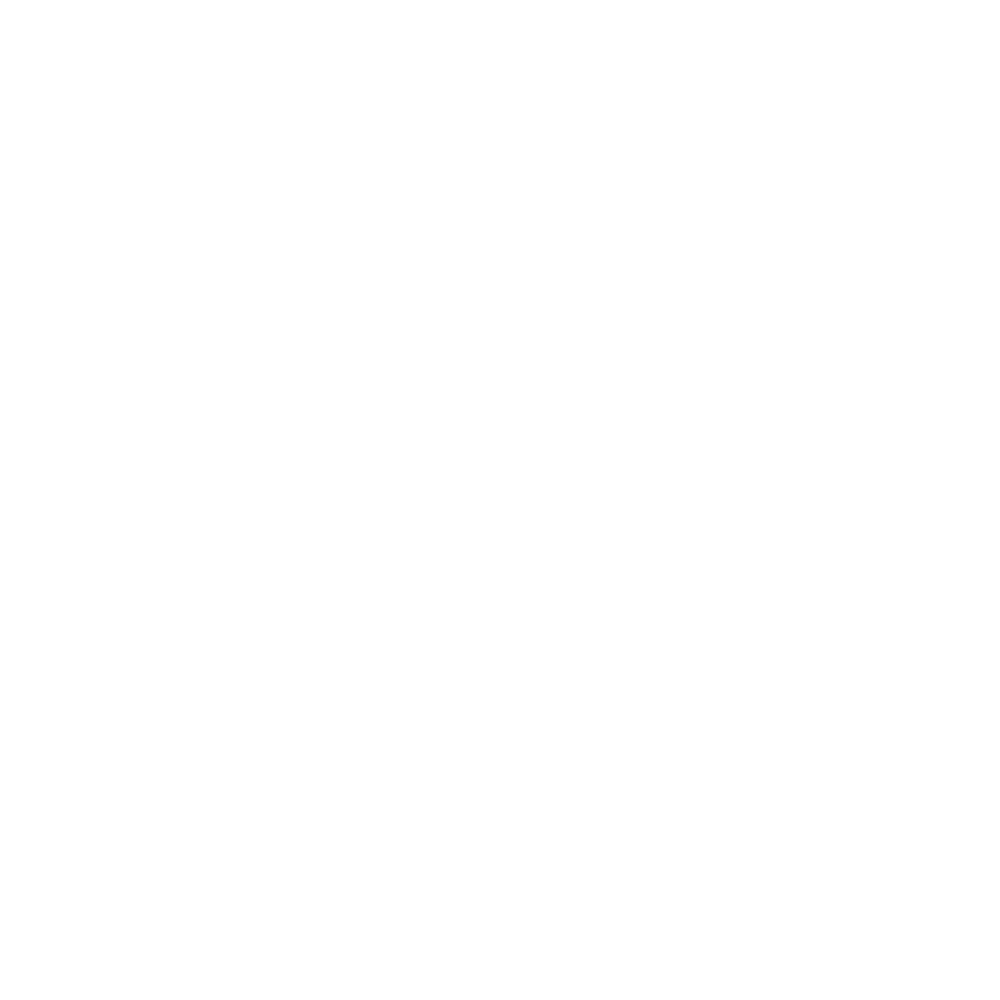

100%|██████████| 1000/1000 [00:01<00:00, 642.43it/s]


Accuracy:  0.282


100%|██████████| 1000/1000 [00:01<00:00, 698.68it/s]


Accuracy:  0.208


100%|██████████| 1000/1000 [00:01<00:00, 697.02it/s]


Accuracy:  0.256


100%|██████████| 1000/1000 [00:01<00:00, 697.66it/s]


Accuracy:  0.322


100%|██████████| 1000/1000 [00:01<00:00, 693.48it/s]


Accuracy:  0.28


100%|██████████| 1000/1000 [00:01<00:00, 690.89it/s]


Accuracy:  0.44


100%|██████████| 1000/1000 [00:01<00:00, 683.38it/s]


Accuracy:  0.358


100%|██████████| 1000/1000 [00:01<00:00, 617.90it/s]


Accuracy:  0.346


100%|██████████| 1000/1000 [00:01<00:00, 650.61it/s]


Accuracy:  0.36


100%|██████████| 1000/1000 [00:01<00:00, 636.77it/s]


Accuracy:  0.36


In [167]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))


m_len = 28 * 28 
tr_len = 60000


prec = 1e-10

# Sparse 1
S1x = 20
S1y = 20

NS1 = S1x * S1y

# Invariant
Ivx = 20
Ivy = 20
hw2 = 0.5

NIv = Ivx * Ivy

# Sparse 2
S2x = 10
S2y = 1
hw3 = 0.5 # How much we weight top-down vs bottom-up


NS2 = S2x * S2y

xi = 0.05


# In - Sparse 1
w1 = cp.random.uniform(0, 0.05, (NS1, m_len))
n_w1 = 1 #Number of winners

# iv_b = (NS1 * NIv)
# iv_t = (NS2 * NIv)

# iv_syn = (iv_b) + (iv_t)
# iv_init = 0.02


# # Sparse 1 - Iv
w2 = cp.random.uniform(0, 0.1, (NS1, 10))
# n_w2 = n_w1 #Number of winners

# # Iv - Sparse 2
# w3 = cp.random.uniform(0, 0.5, (NS2, NIv))
# n_w3 = 1

# # Sparse 2 - Class
# w4 = cp.random.uniform(0, 0.1, (NS2, 10))

# Count Passes
passthrough_count = 2 # How many times we go back and forth through the network
show_count = 4

debug = False
de2 = False

Nep = 10
T_s = 1000
hw1 = .5 # How much we weight top-down vs bottom-up

for ep in range(Nep):
    rand_pert = np.random.permutation(tr_len)
#     rand_pert = list(range(tr_len)) # JUST FOR DEBUGGING
    inputs = gp_ftr[rand_pert]
    outputs = gp_cr[rand_pert]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        cl = outputs[i].reshape(-1, 1)

        s1_bottom = cp.zeros((NS1, 1))
        s1_top = cp.zeros((NS1, 1))
        
        iv_bottom = cp.zeros((NIv, 1))
        iv_top = cp.zeros((NIv, 1))
        
        s2_bottom = cp.zeros((NS2, 1))
        s2_top = cp.zeros((NS2, 1))
        
        
        def calc_s1():
            global s1_bottom, s1_top
            
            s1_bottom = w1 @ v
            s1_top = w2 @ cl
            
            s1_comp = (hw1 * s1_bottom / cp.max(s1_bottom)) + ((1 - hw1) * s1_top / cp.max(s1_top))
            s1_winners = cp.argsort(s1_comp, axis=0)[-n_w1:]
            s1_top = cp.zeros((NS1, 1))
            s1_top[s1_winners] = 1
            s1_bottom *= s1_top
            
#         def calc_iv():
#             global iv_bottom, iv_top
            
#             iv_bottom = w2.T @ s1_top
#             iv_top = w3.T @ s2_bottom
#             iv_comp = (hw2 * iv_bottom / cp.max(iv_bottom)) + ((1 - hw2) * iv_top / cp.max(iv_top))
            
#             iv_winners = cp.argsort(iv_comp, axis=0)[-n_w2:]
#             iv_top = cp.zeros((NIv, 1))
#             iv_top[iv_winners] = 1
#             iv_bottom = iv_top
            
#         def calc_s2():
#             global s2_bottom, s2_top
            
#             s2_bottom = w3 @ iv_top
#             s2_top = w4 @ cl
#             s2_comp = (hw3 * s2_bottom / cp.max(s2_bottom)) + ((1 - hw3) * s2_top / cp.max(s2_top))
            
#             s2_winners = cp.argsort(s2_comp, axis=0)[-n_w3:]
#             s2_top = cp.zeros((NS2, 1))
#             s2_top[s2_winners] = 1
#             s2_bottom *= s2_top
            
        
#         for _ in range(passthrough_count): 
        calc_s1()
#             calc_iv()
#             calc_s2()
#             calc_iv()
        
        
        r1 = w1.T @ s1_bottom
        mod_r1 = cp.maximum(r1, prec)
        e1 = v - r1

        
        cc1 = w1 * s1_bottom * (e1 / mod_r1).T * xi
        w1 += cc1        
                
        r2 = w2.T @ s1_top
        mod_r2 = cp.maximum(r2, prec)
        e2 = cl - r2
        
        w2 += w2 * s1_top * (e2 / mod_r2).T * xi
                
#         r3 = w3.T @ s2_bottom
#         mod_r3 = cp.maximum(r3, prec)
#         e3 = iv_top - r3
        
#         w3 += w3 * s2_bottom * (e3 / mod_r3).T * xi
            
#         r4 = w4.T @ s2_top
#         mod_r4 = cp.maximum(r4, prec)
#         e4 = cl - r4
        
#         w4 += w4 * s2_top * (e4 / mod_r4).T * xi
        
#         if i % 50 == 0:
#             w1 += cp.random.uniform(0, 0.001, (NS1, m_len))
#             w2 += cp.random.uniform(0, 0.01, (NS1, NIv))
#             w3 += cp.random.uniform(0, 0.05, (NS2, NIv))
#             w4 += cp.random.uniform(0, 0.05, (NS2, 10))
        
#     draw_higher_order_weights(fig)
    accuracy_m(500)

In [164]:
def classify_m(i):
    v = gp_fte[i].reshape(-1, 1)
    cl = gp_ce[i].reshape(-1, 1)

    s1_bottom = cp.zeros((NS1, 1))
    s1_top = cp.zeros((NS1, 1))

    iv_bottom = cp.zeros((NIv, 1))
    iv_top = cp.zeros((NIv, 1))

    s2_bottom = cp.zeros((NS2, 1))
    s2_top = cp.zeros((NS2, 1))

    s1_bottom = w1 @ v

    s1_comp = (hw1 * s1_bottom / cp.max(s1_bottom)) # + ((1 - hw1) * s1_top / cp.max(s1_top))
    s1_winners = cp.argsort(s1_comp, axis=0)[-n_w1:]
    s1_top = cp.zeros((NS1, 1))
    s1_top[s1_winners] = 1
    s1_bottom *= s1_top

    cls = w2.T @ s1_top
#     iv_comp = (hw2 * iv_bottom / cp.max(iv_bottom)) #+ ((1 - hw2) * iv_top / cp.max(iv_top))

#     iv_winners = cp.argsort(iv_comp, axis=0)[-n_w2:]
#     iv_top = cp.zeros((NIv, 1))
#     iv_top[iv_winners] = 1
#     iv_bottom = iv_top

#     s2_bottom = w3 @ 
#     s2_comp = (hw3 * s2_bottom / cp.max(s2_bottom)) # + ((1 - hw3) * s2_top / cp.max(s2_top))

#     s2_winners = cp.argsort(s2_comp, axis=0)[-n_w3:]
#     s2_top = cp.zeros((NS2, 1))
#     s2_top[s2_winners] = 1
#     s2_bottom *= s2_top
    
#     cls = w4.T @ s2_top
    
    pred = cp.argmax(cls)
    real = cp.argmax(cl)
    
    return pred == real, pred, real

def accuracy_m(num):
    total = 0
    for i in range(num):
        corr, _, _ = classify_m(i)
        if corr:
            total += 1
    print("Accuracy: ", total / num)


In [165]:
accuracy_m(10)

Accuracy:  0.4


In [166]:
accuracy_m(100)


Accuracy:  0.38


<IPython.core.display.Javascript object>


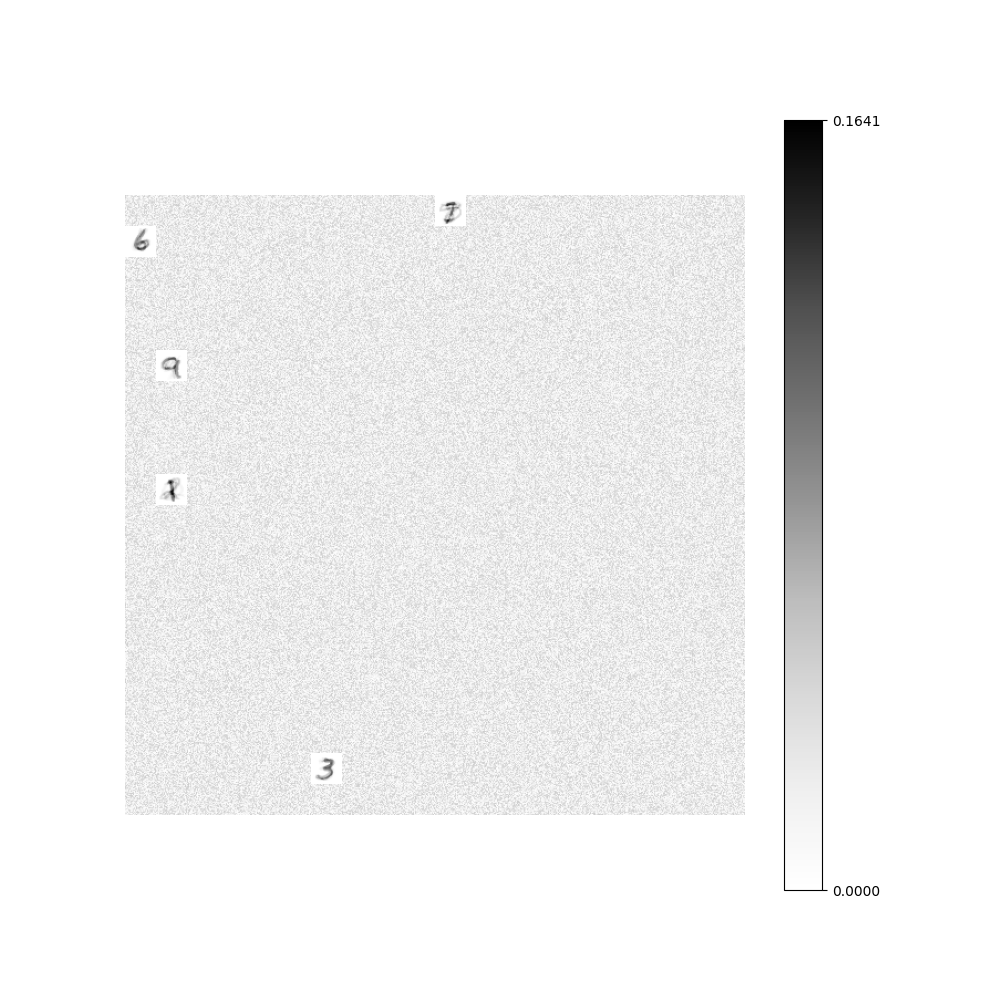

In [168]:
fig = plt.figure(figsize=(10, 10))
draw_weights(w1.get(), S1x, S1y, 28, fig)

Ok, it's 1 and I'm tired and this isn't fucking working.  FUCK. fuck. fUcK.  FuCK.

Whatever.  Fuck.  I'll maybe think about this tomorrow...